# Анализ композиционных материалов

## Постановка задачи

На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов. Кейс основан на реальных производственных задачах Центра НТИ «Цифровое материаловедение: новые материалы и вещества» (структурное подразделение МГТУ им. Н.Э. Баумана)

## Установка окружения

In [ ]:
%%capture


%conda install tensorflow-cpu pandas numpy seaborn matplotlib scipy scikit-learn openpyxl

In [ ]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

# вывод всех выходов каждой ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

2023-04-20 18:32:10.863502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Чтение данных

In [ ]:
ds1 = pd.read_excel('X_bp.xlsx') 
ds2 = pd.read_excel('X_nup.xlsx')
# объединяем датасеты
ds = pd.merge(ds1, ds2)
# устраняем строки для которых не нашлось индекса (один датасет больше другого)
ds.dropna(inplace=True)
# инспектируем перые 5 строк таблицы
ds.head(5)

Unnamed: 0  Соотношение матрица-наполнитель  Плотность, кг/м3   
0           0                         1.857143            2030.0  \
1           1                         1.857143            2030.0   
2           2                         1.857143            2030.0   
3           3                         1.857143            2030.0   
4           4                         2.771331            2030.0   

   модуль упругости, ГПа  Количество отвердителя, м.%   
0             738.736842                        30.00  \
1             738.736842                        50.00   
2             738.736842                        49.90   
3             738.736842                       129.00   
4             753.000000                       111.86   

   Содержание эпоксидных групп,%_2  Температура вспышки, С_2   
0                        22.267857                100.000000  \
1                        23.750000                284.615385   
2                        33.000000                284.615385   
3                        21.250000                300.000000   
4                        22.267857                284.615385   

   Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа   
0                          210.0                                  70.0  \
1                          210.0                                  70.0   
2                          210.0                                  70.0   
3                          210.0                                  70.0   
4                          210.0                                  70.0   

   Прочность при растяжении, МПа  Потребление смолы, г/м2  Угол нашивки, град   
0                         3000.0                    220.0                   0  \
1                         3000.0                    220.0                   0   
2                         3000.0                    220.0                   0   
3                         3000.0                    220.0                   0   
4                         3000.0                    220.0                   0   

   Шаг нашивки  Плотность нашивки  
0          4.0               57.0  
1          4.0               60.0  
2          4.0               70.0  
3          5.0               47.0  
4          5.0               57.0

In [ ]:
# удалим первый столбец, который дублирует индекс
ds.drop('Unnamed: 0', axis=1, inplace=True)

# сформируем матрицу признаков и матрицу целевых показателей для последующего анализа
# NOTE(!!!): здесь можно варировать, что является выходом модели, т.к. из файлов непонятно
y_labels = ['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']
# y_labels = ['Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки']
y = ds[y_labels]
X = ds.drop(y_labels, axis=1)

# проверим, что количество элементов входа соответствует количеству элементов выхода
assert X.shape[0] == y.shape[0]

# сохраним один кейс на будущее
ex_x = X.loc[42]
ex_y = y.loc[42]

In [ ]:
# посмотрим сводную статистику входных признаков
X.describe().T
# и сводную статистику выходных признаков
y.describe().T

count         mean         std          min   
Соотношение матрица-наполнитель  1023.0     2.930366    0.913222     0.389403  \
Плотность, кг/м3                 1023.0  1975.734888   73.729231  1731.764635   
модуль упругости, ГПа            1023.0   739.923233  330.231581     2.436909   
Количество отвердителя, м.%      1023.0   110.570769   28.295911    17.740275   
Содержание эпоксидных групп,%_2  1023.0    22.244390    2.406301    14.254985   
Температура вспышки, С_2         1023.0   285.882151   40.943260   100.000000   
Поверхностная плотность, г/м2    1023.0   482.731833  281.314690     0.603740   
Потребление смолы, г/м2          1023.0   218.423144   59.735931    33.803026   
Угол нашивки, град               1023.0    44.252199   45.015793     0.000000   
Шаг нашивки                      1023.0     6.899222    2.563467     0.000000   
Плотность нашивки                1023.0    57.153929   12.350969     0.000000   

                                         25%          50%          75%   
Соотношение матрица-наполнитель     2.317887     2.906878     3.552660  \
Плотность, кг/м3                 1924.155467  1977.621657  2021.374375   
модуль упругости, ГПа             500.047452   739.664328   961.812526   
Количество отвердителя, м.%        92.443497   110.564840   129.730366   
Содержание эпоксидных групп,%_2    20.608034    22.230744    23.961934   
Температура вспышки, С_2          259.066528   285.896812   313.002106   
Поверхностная плотность, г/м2     266.816645   451.864365   693.225017   
Потребление смолы, г/м2           179.627520   219.198882   257.481724   
Угол нашивки, град                  0.000000     0.000000    90.000000   
Шаг нашивки                         5.080033     6.916144     8.586293   
Плотность нашивки                  49.799212    57.341920    64.944961   

                                         max  
Соотношение матрица-наполнитель     5.591742  
Плотность, кг/м3                 2207.773481  
модуль упругости, ГПа            1911.536477  
Количество отвердителя, м.%       198.953207  
Содержание эпоксидных групп,%_2    33.000000  
Температура вспышки, С_2          413.273418  
Поверхностная плотность, г/м2    1399.542362  
Потребление смолы, г/м2           414.590628  
Угол нашивки, град                 90.000000  
Шаг нашивки                        14.440522  
Плотность нашивки                 103.988901

count         mean         std   
Модуль упругости при растяжении, ГПа  1023.0    73.328571    3.118983  \
Прочность при растяжении, МПа         1023.0  2466.922843  485.628006   

                                              min          25%          50%   
Модуль упругости при растяжении, ГПа    64.054061    71.245018    73.268805  \
Прочность при растяжении, МПа         1036.856605  2135.850448  2459.524526   

                                              75%          max  
Модуль упругости при растяжении, ГПа    75.356612    82.682051  
Прочность при растяжении, МПа         2767.193119  3848.436732

In [6]:
# проанализируем количество дубликатов входных признаков
X.duplicated().sum()
# проанализируем количество пропущенных значений
X.isna().sum()
y.isna().sum()

0

Соотношение матрица-наполнитель    0
Плотность, кг/м3                   0
модуль упругости, ГПа              0
Количество отвердителя, м.%        0
Содержание эпоксидных групп,%_2    0
Температура вспышки, С_2           0
Поверхностная плотность, г/м2      0
Потребление смолы, г/м2            0
Угол нашивки, град                 0
Шаг нашивки                        0
Плотность нашивки                  0
dtype: int64

Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
dtype: int64

### Вывод

Мы проанализировали данные с точки зрения статистики и возможных чисток. В итоге сформировали вектор входных признаков и целевых показателелей для последующего анализа. Т.к. нет пропущенных значений и нет дубликатов входных векторов, то чистки не требуются. Далее будет произведен анализ распределения входных-выходных значений.

## Анализ данных

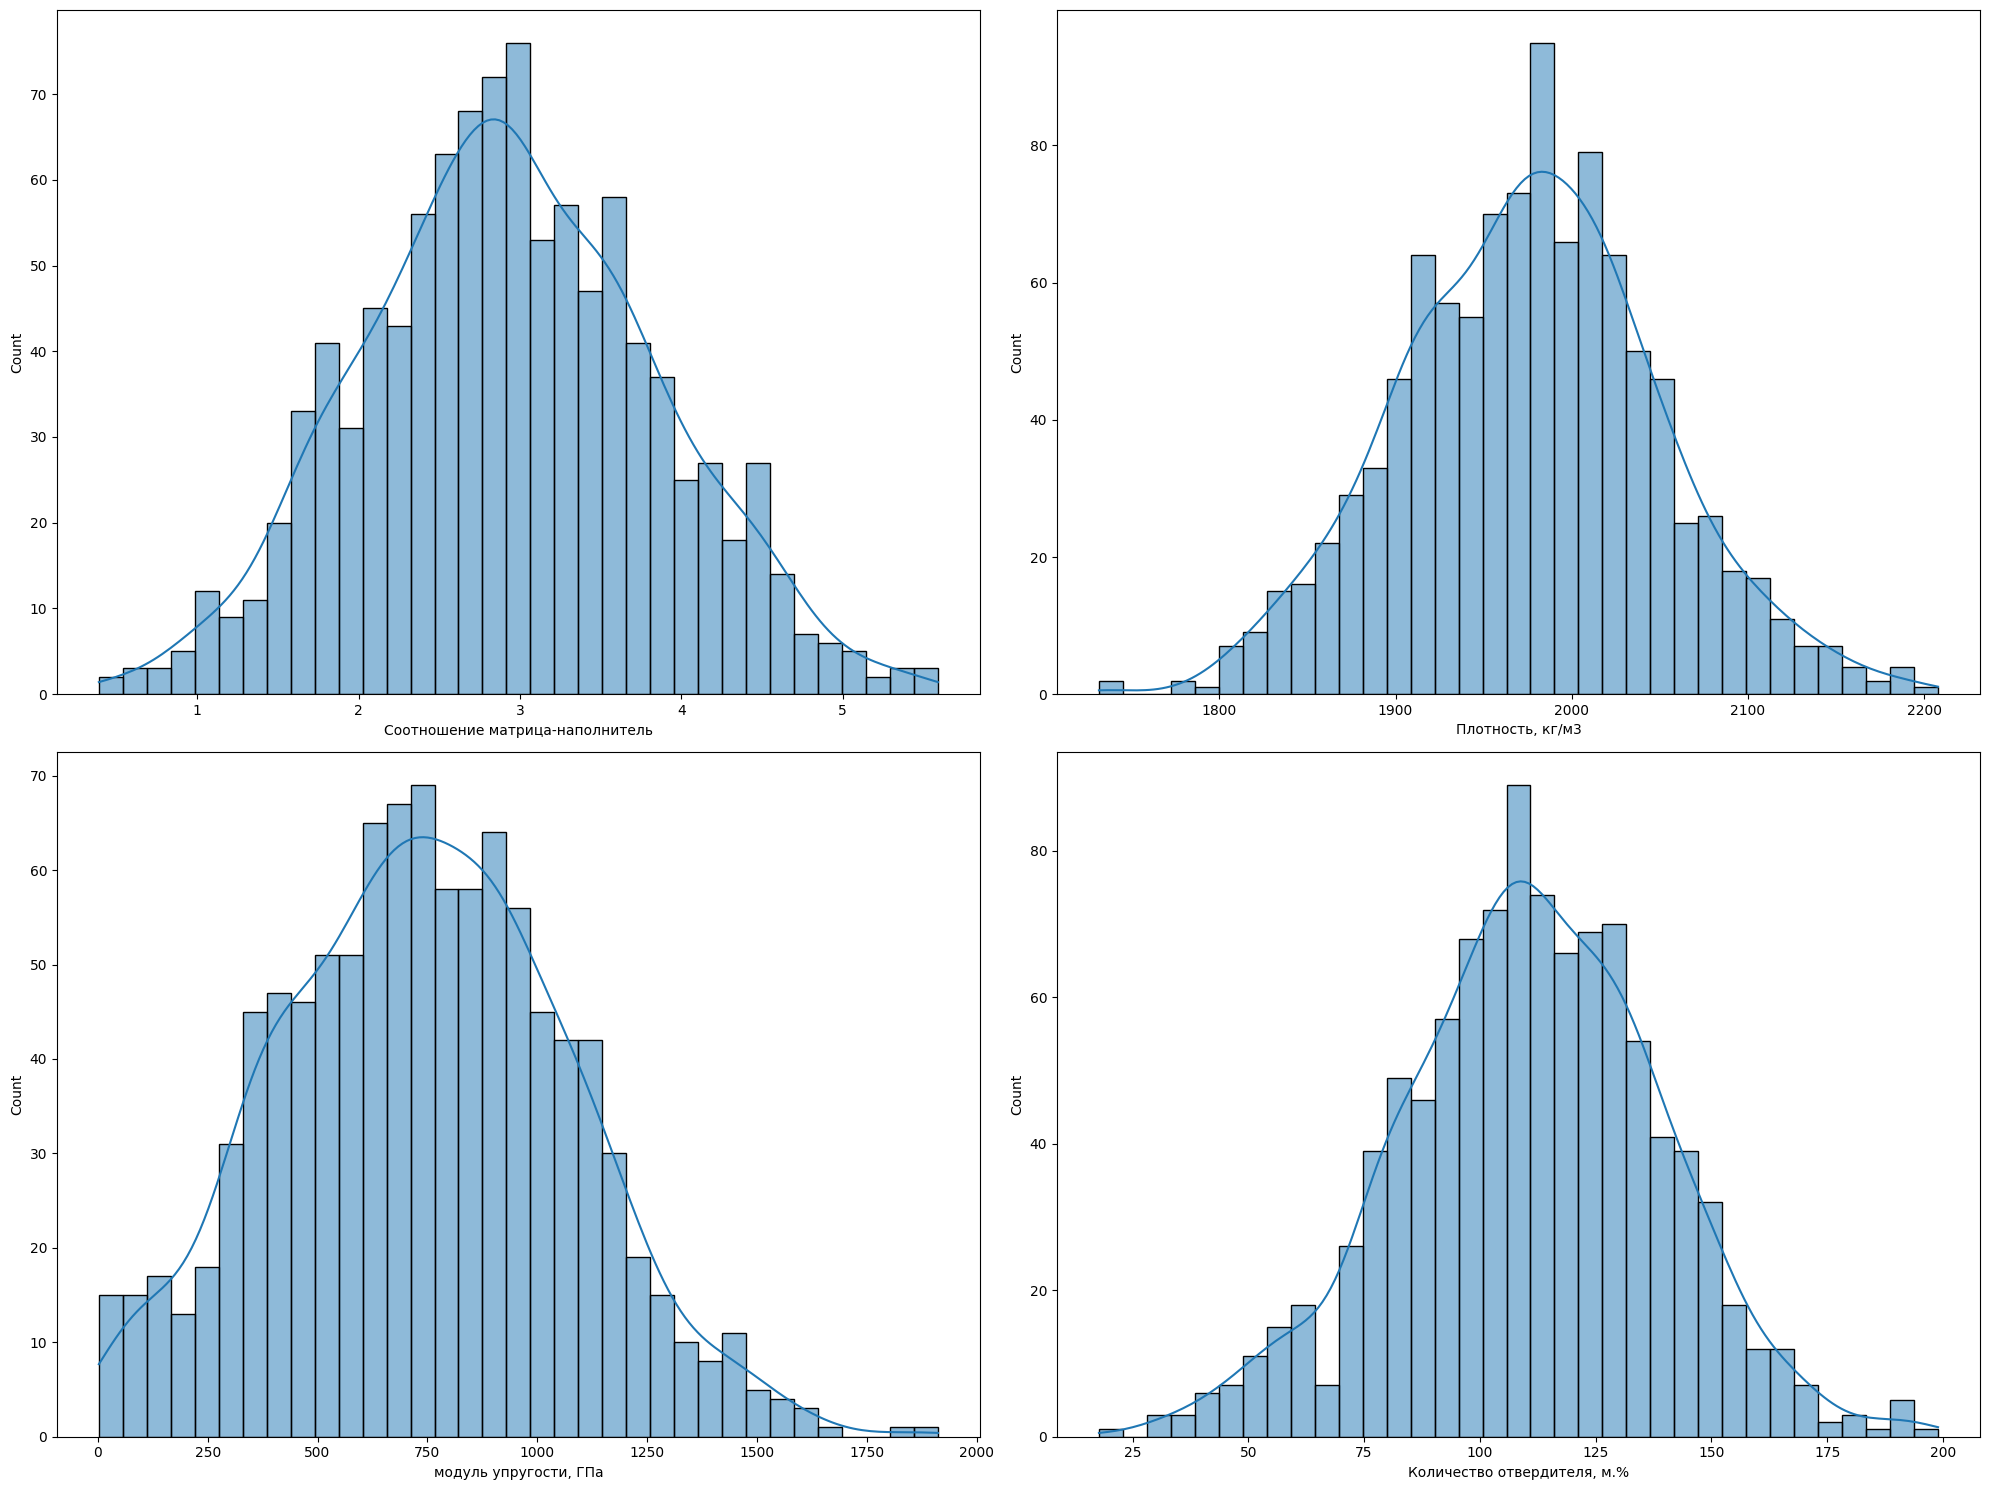

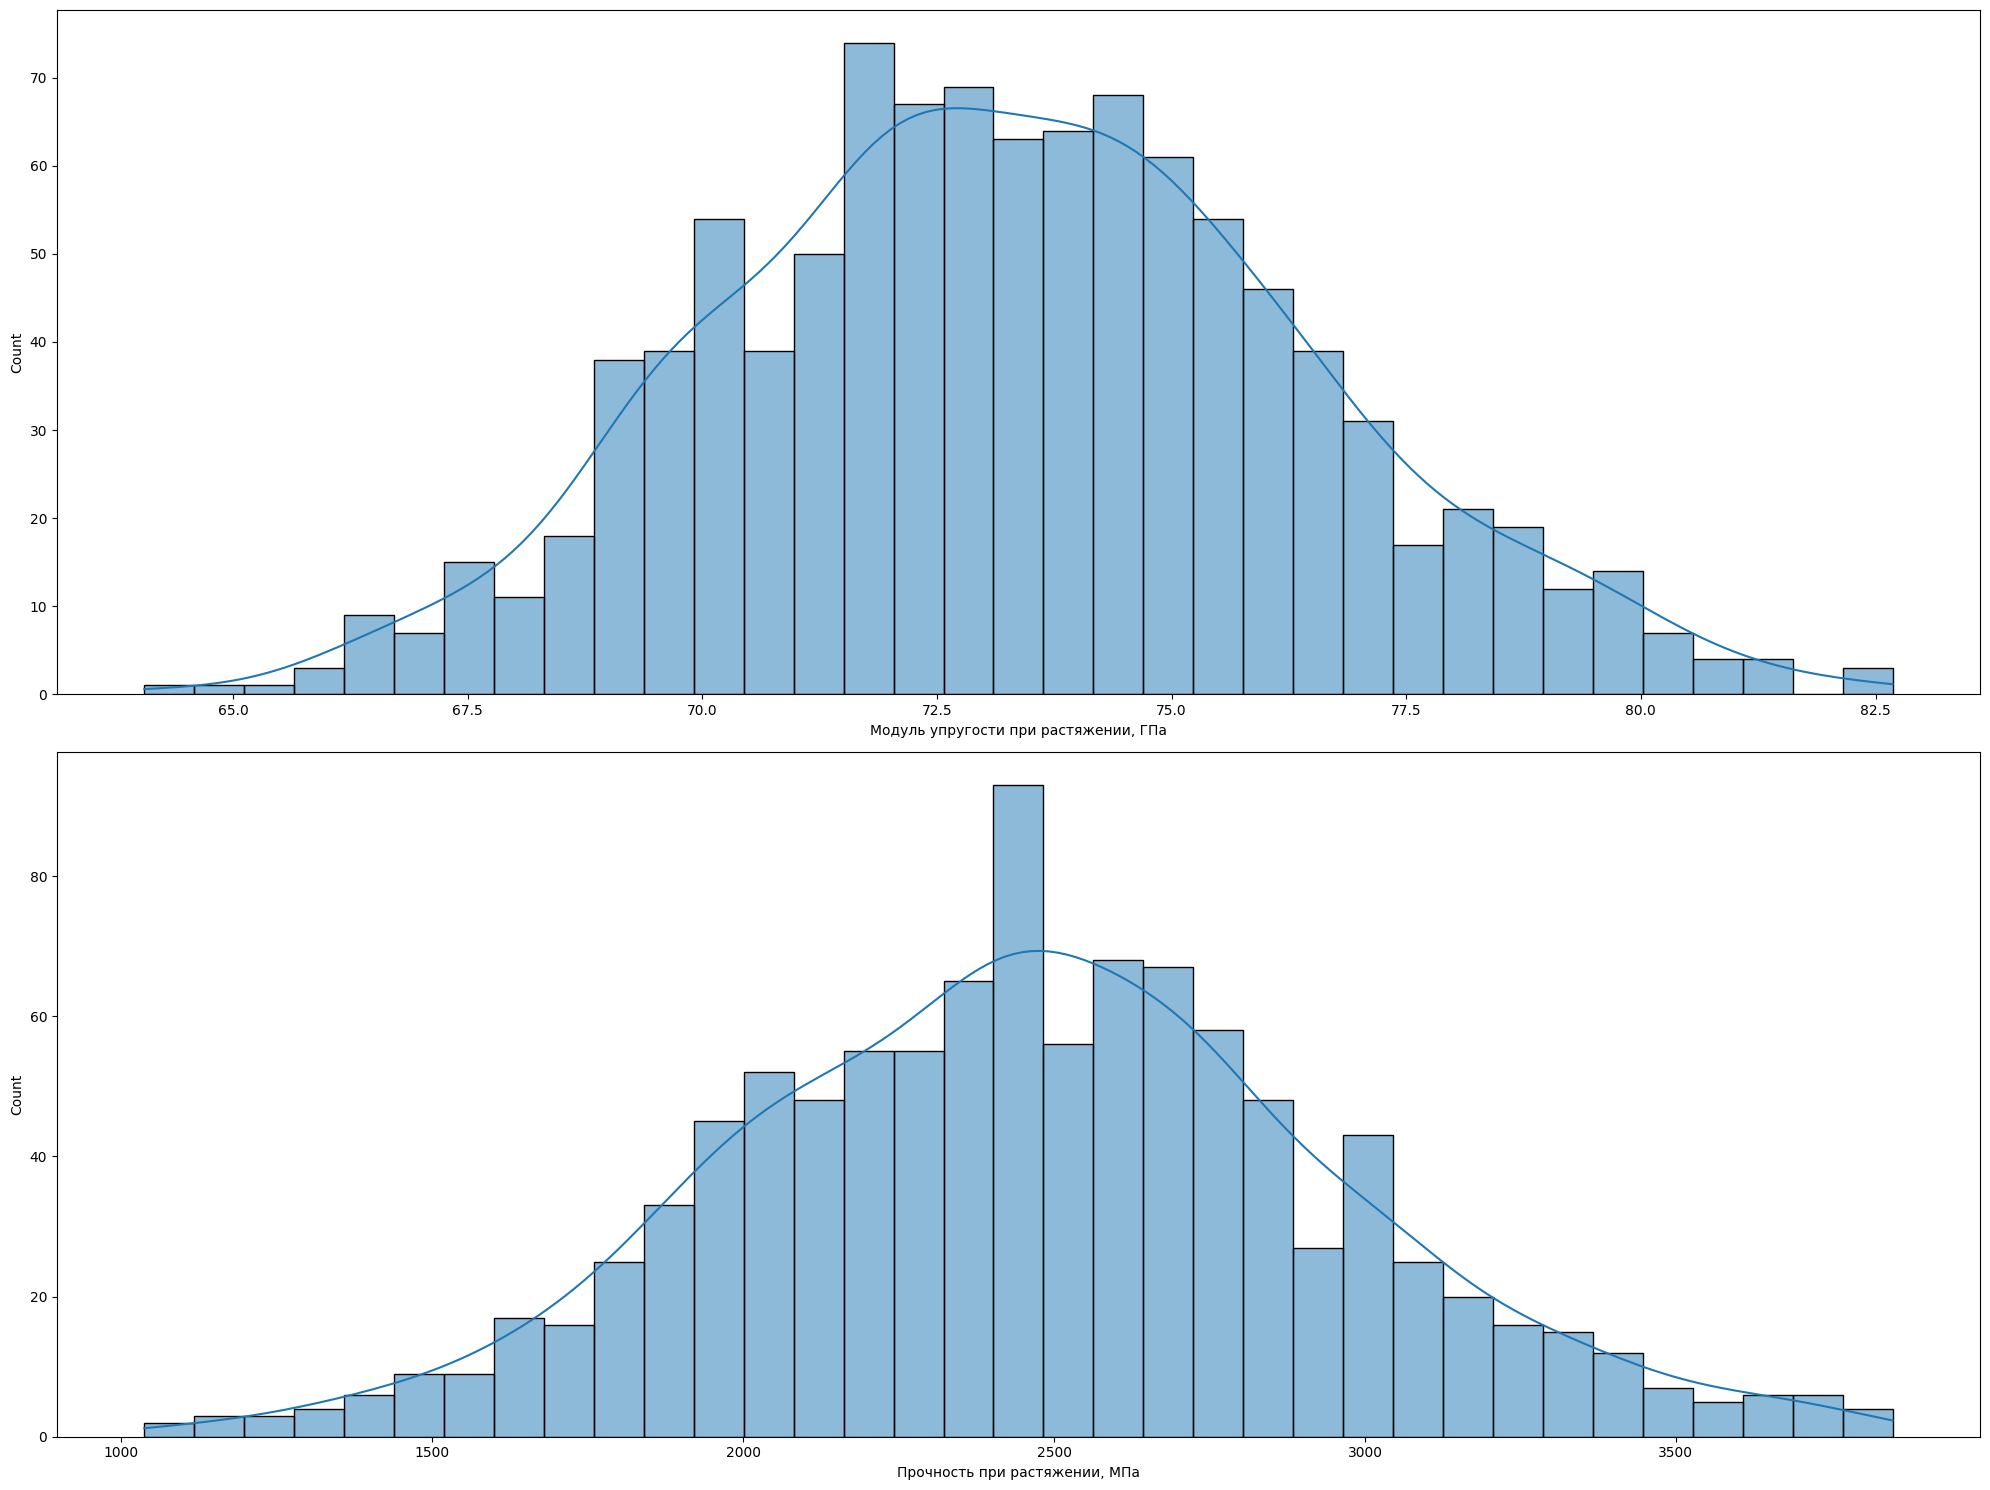

In [7]:
# первым делом посмотрим на гистограммы распределения входных признаков и выходных целевых показателей
# реализуем для этого функцию визуализации гистограммы и запустим ее от соответствующих данных

def build_hist(_df, _n_rows, _n_cols):
    _fig, _ax = plt.subplots(_n_rows, _n_cols, figsize=(20, 15))
    # обработка случая когда матрица под-графиков не двумерная
    _ax = _ax.reshape((_n_rows, _n_cols))
    _data_col = 0
    for _i in range(_n_rows):
        for _j in range(_n_cols):
            sns.histplot(data=_df, x=_df.columns[_data_col], kde=True, bins=35, ax=_ax[_i, _j])
            _data_col += 1
    _fig.tight_layout()
    return _fig

fig_x = build_hist(X, 2, 2)
fig_y = build_hist(y, 2, 1)
plt.show()

<Figure size 2000x2000 with 0 Axes>

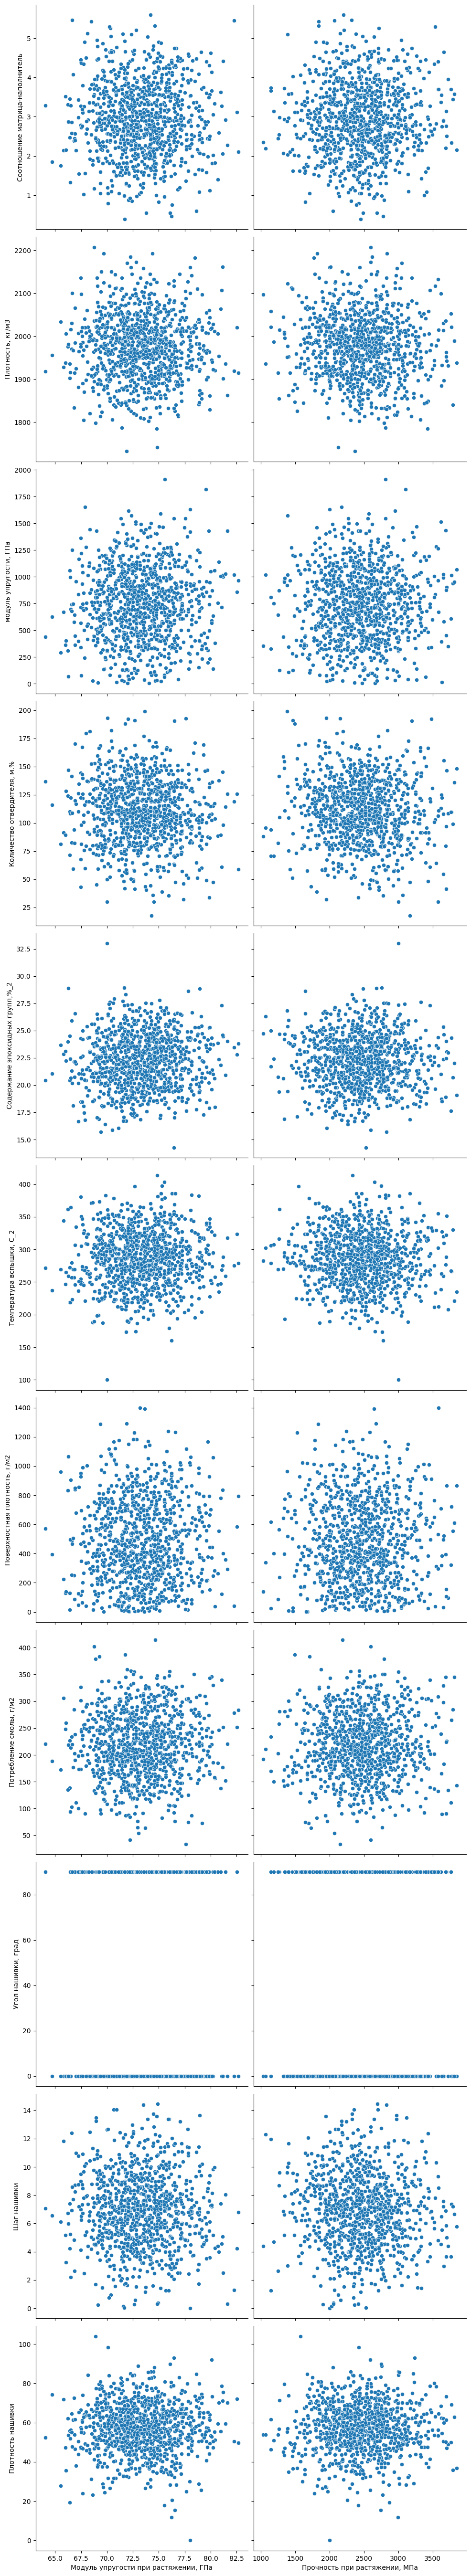

In [8]:
# рассмотрим графики рассеивания в привязке к целевой переменной для каждого признака
fig = plt.figure(figsize=(20, 20))
sns.pairplot(ds, x_vars=y.columns.tolist(), y_vars=X.columns.tolist(), height=5)
plt.show()

<Axes: >

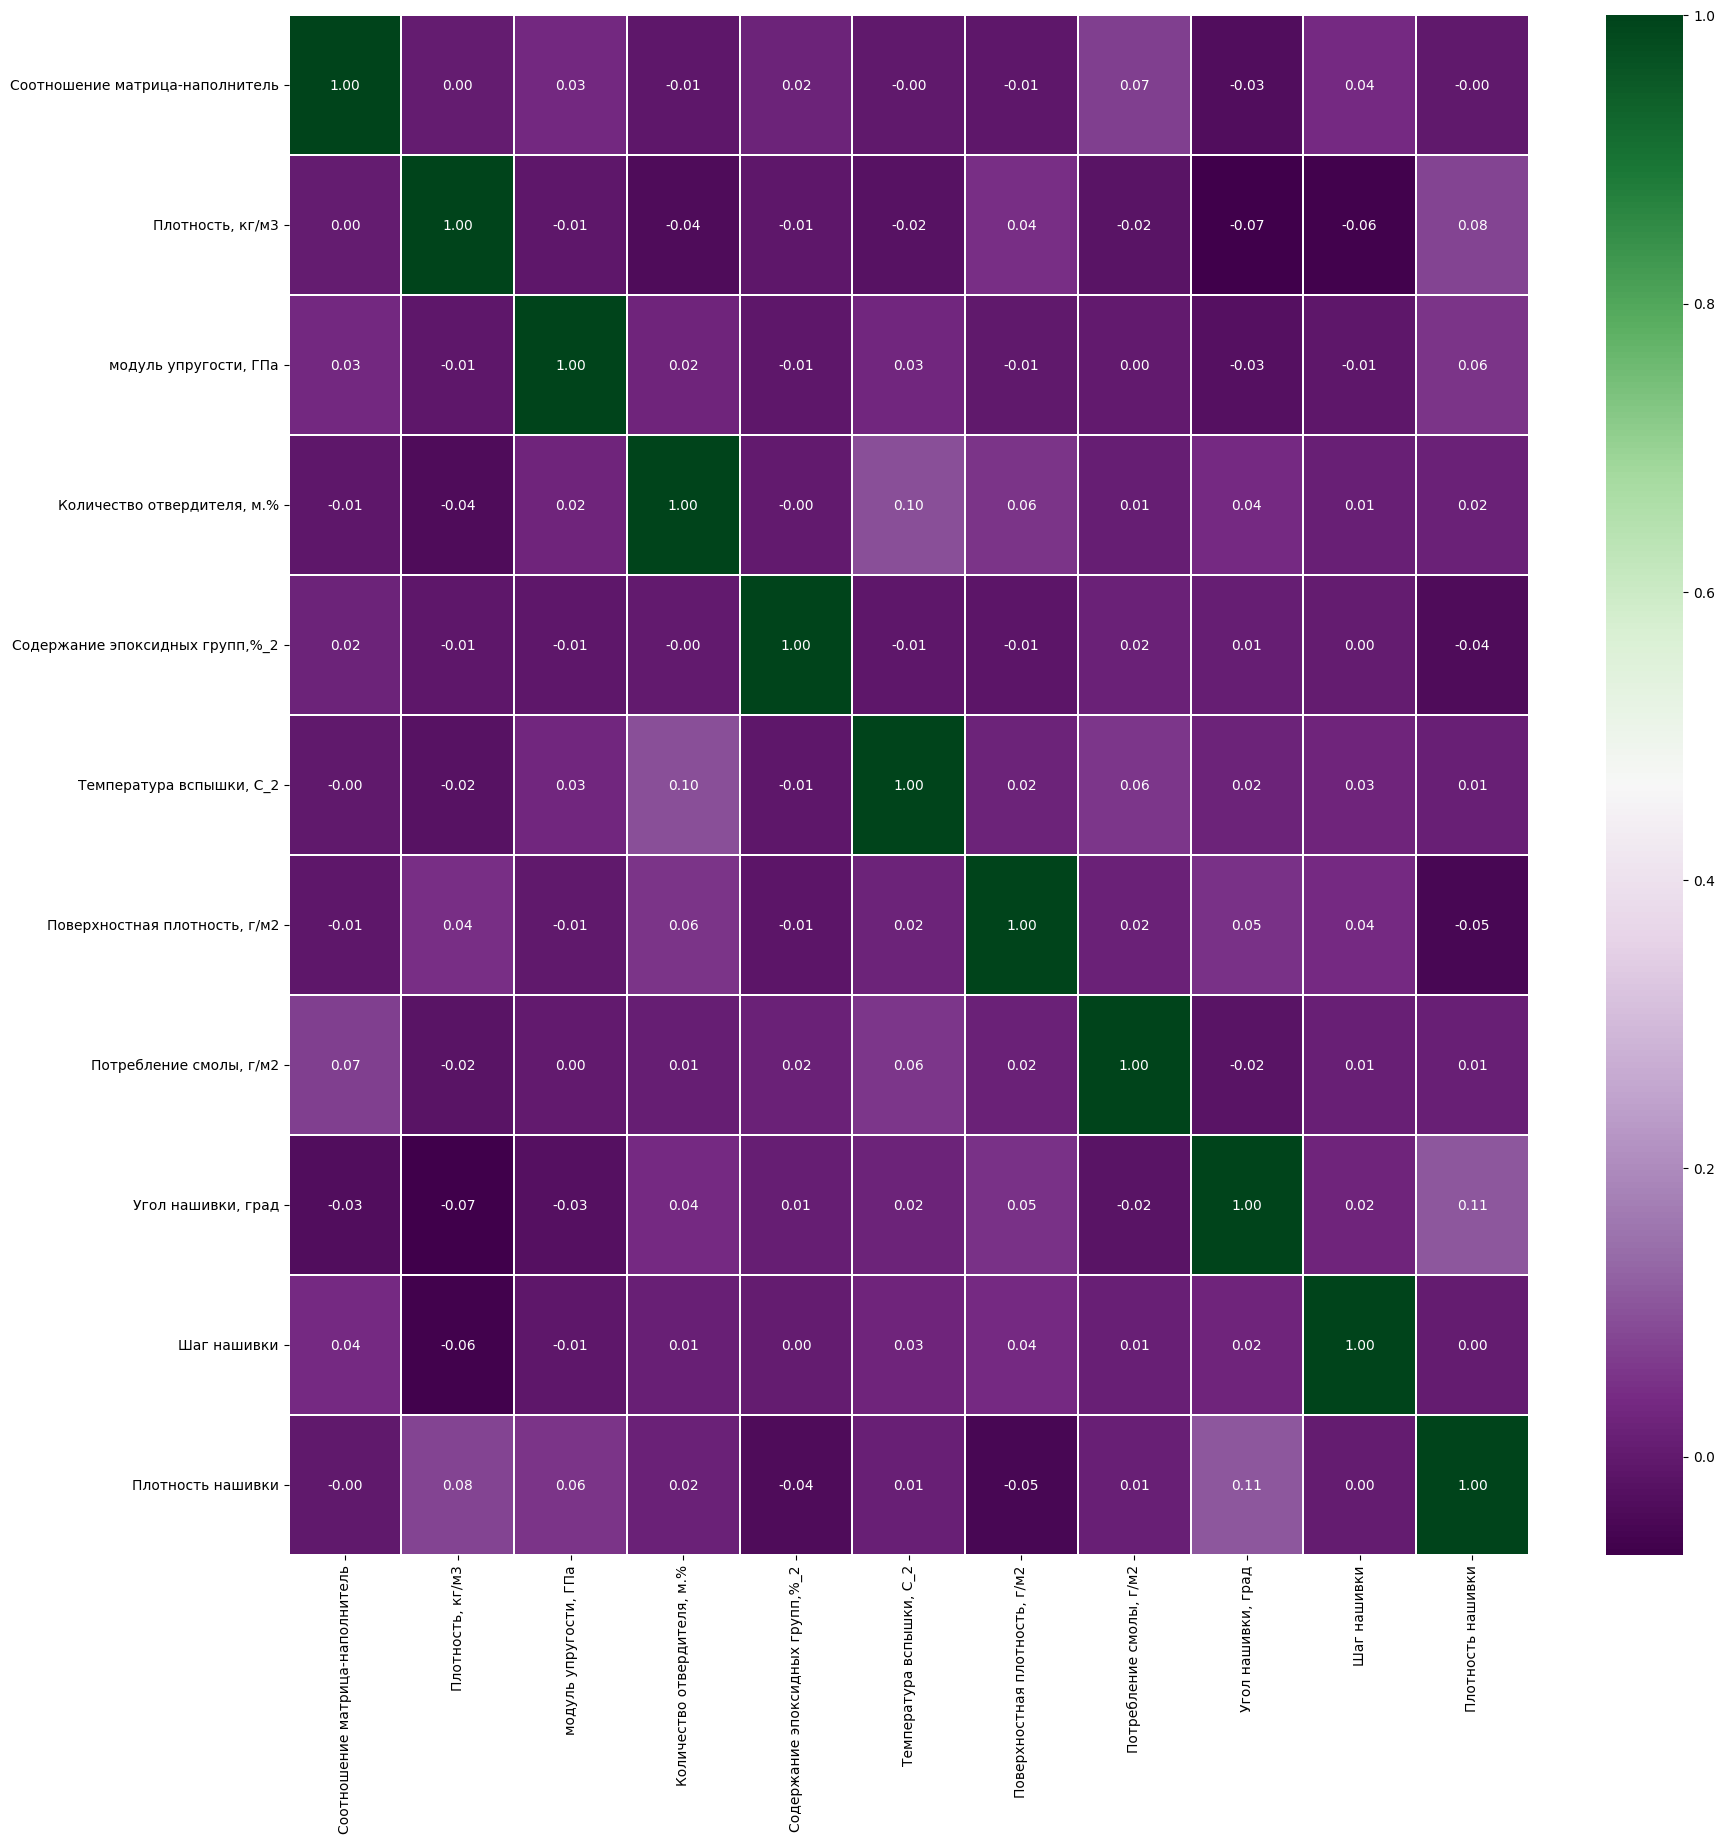

In [9]:
# рассмотрим матрицу корреляции между признаками
corr_x = X.corr()
fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_x, annot=True, fmt='.2f',cmap='PRGn', linewidths=0.1)
plt.show()

<Axes: >

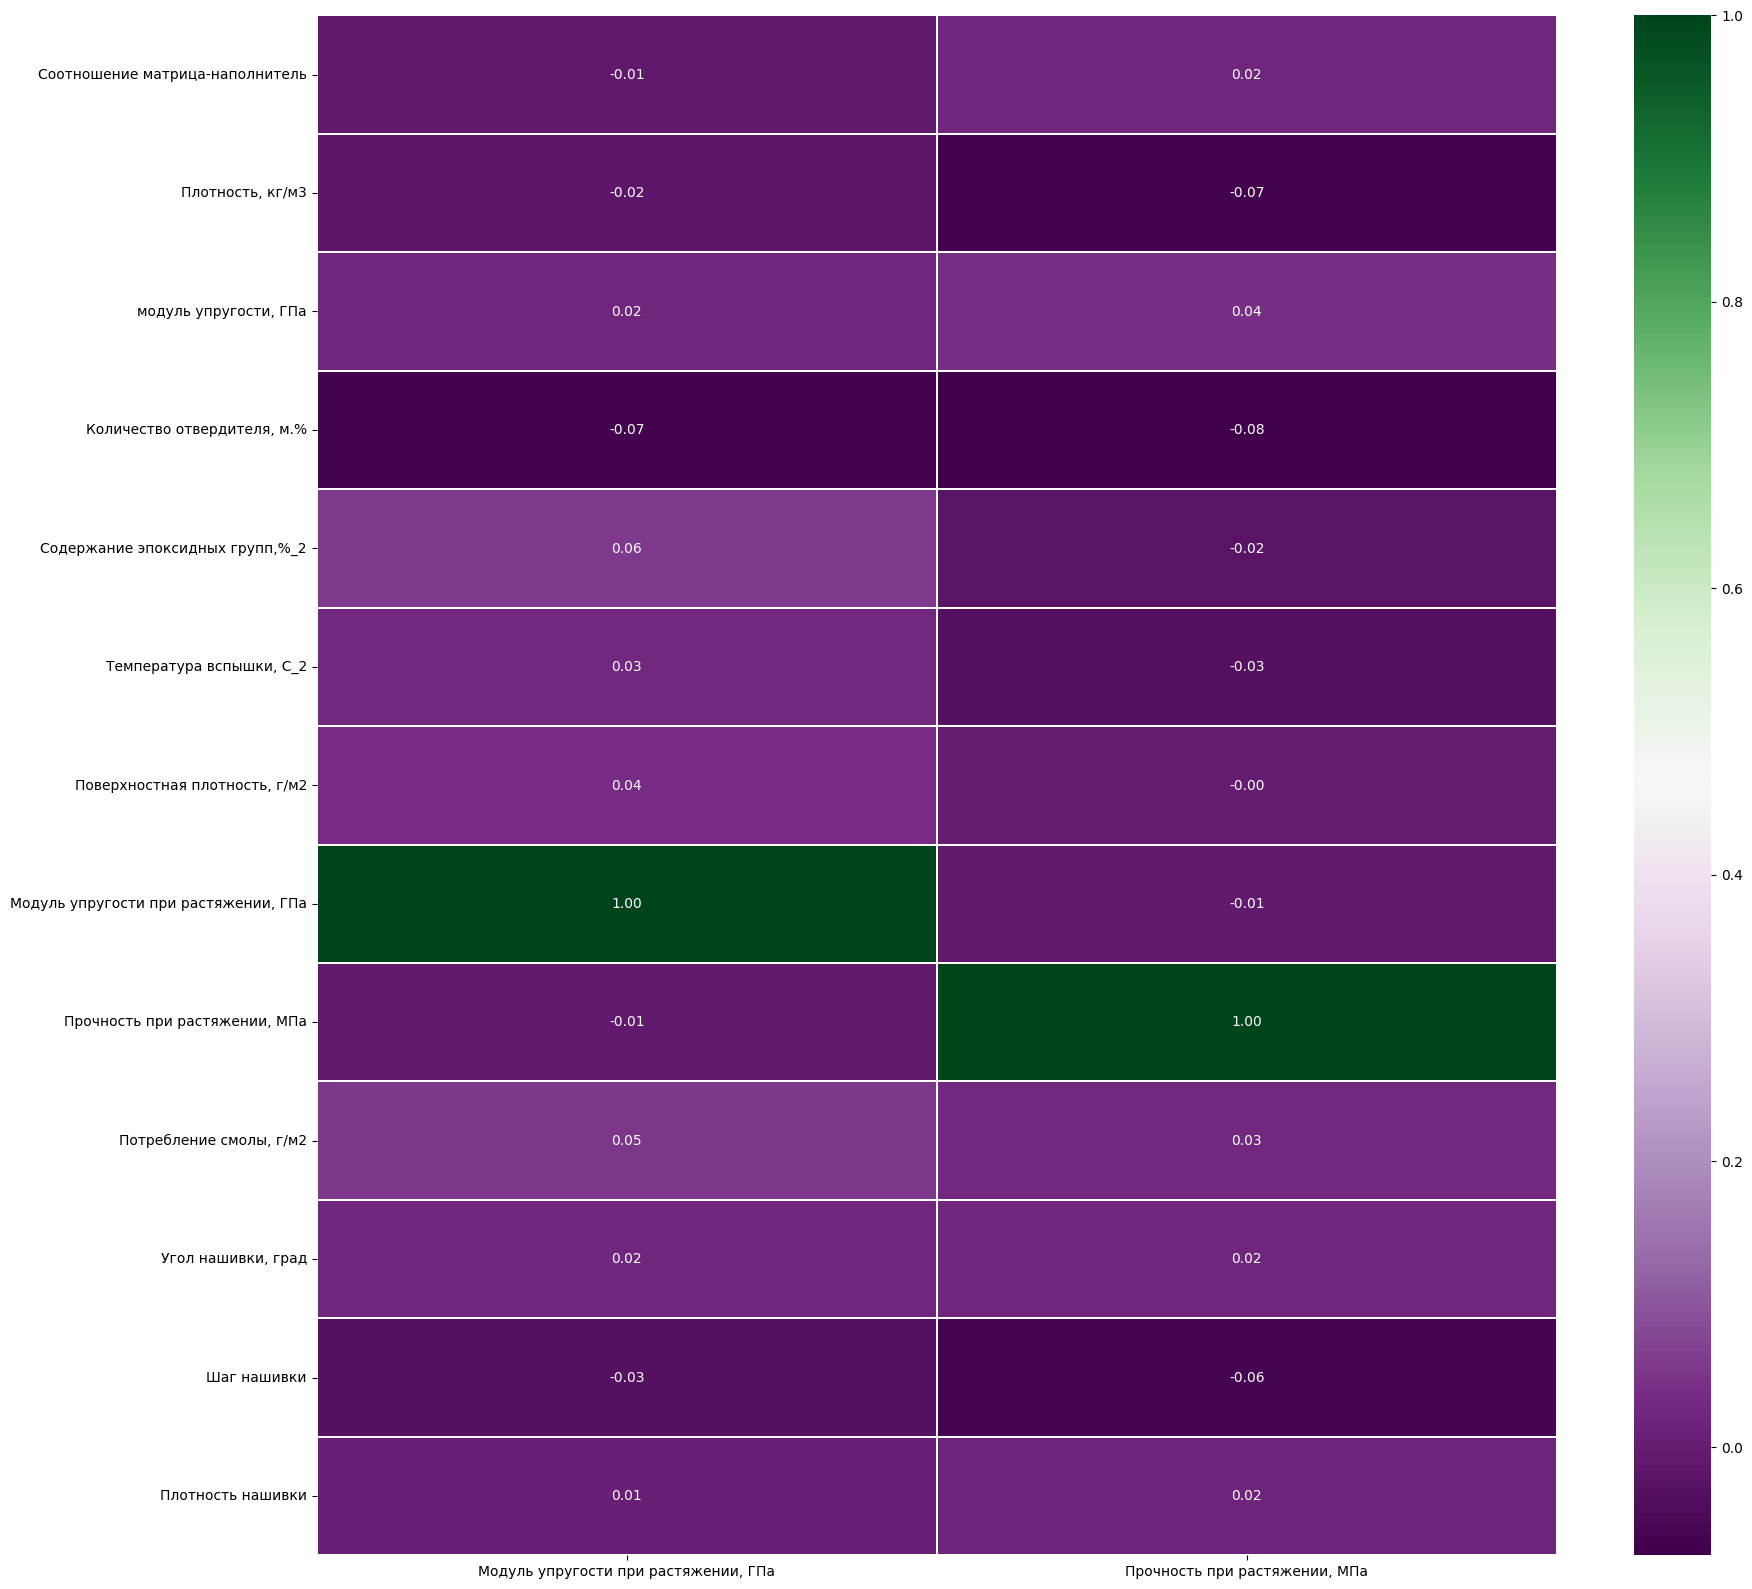

In [10]:
# рассмотрим матрицу корреляции между входными и выходными значениями
corr = ds.corr()
corr = corr[y_labels]
fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f',cmap='PRGn', linewidths=0.1)
plt.show()

<Axes: >

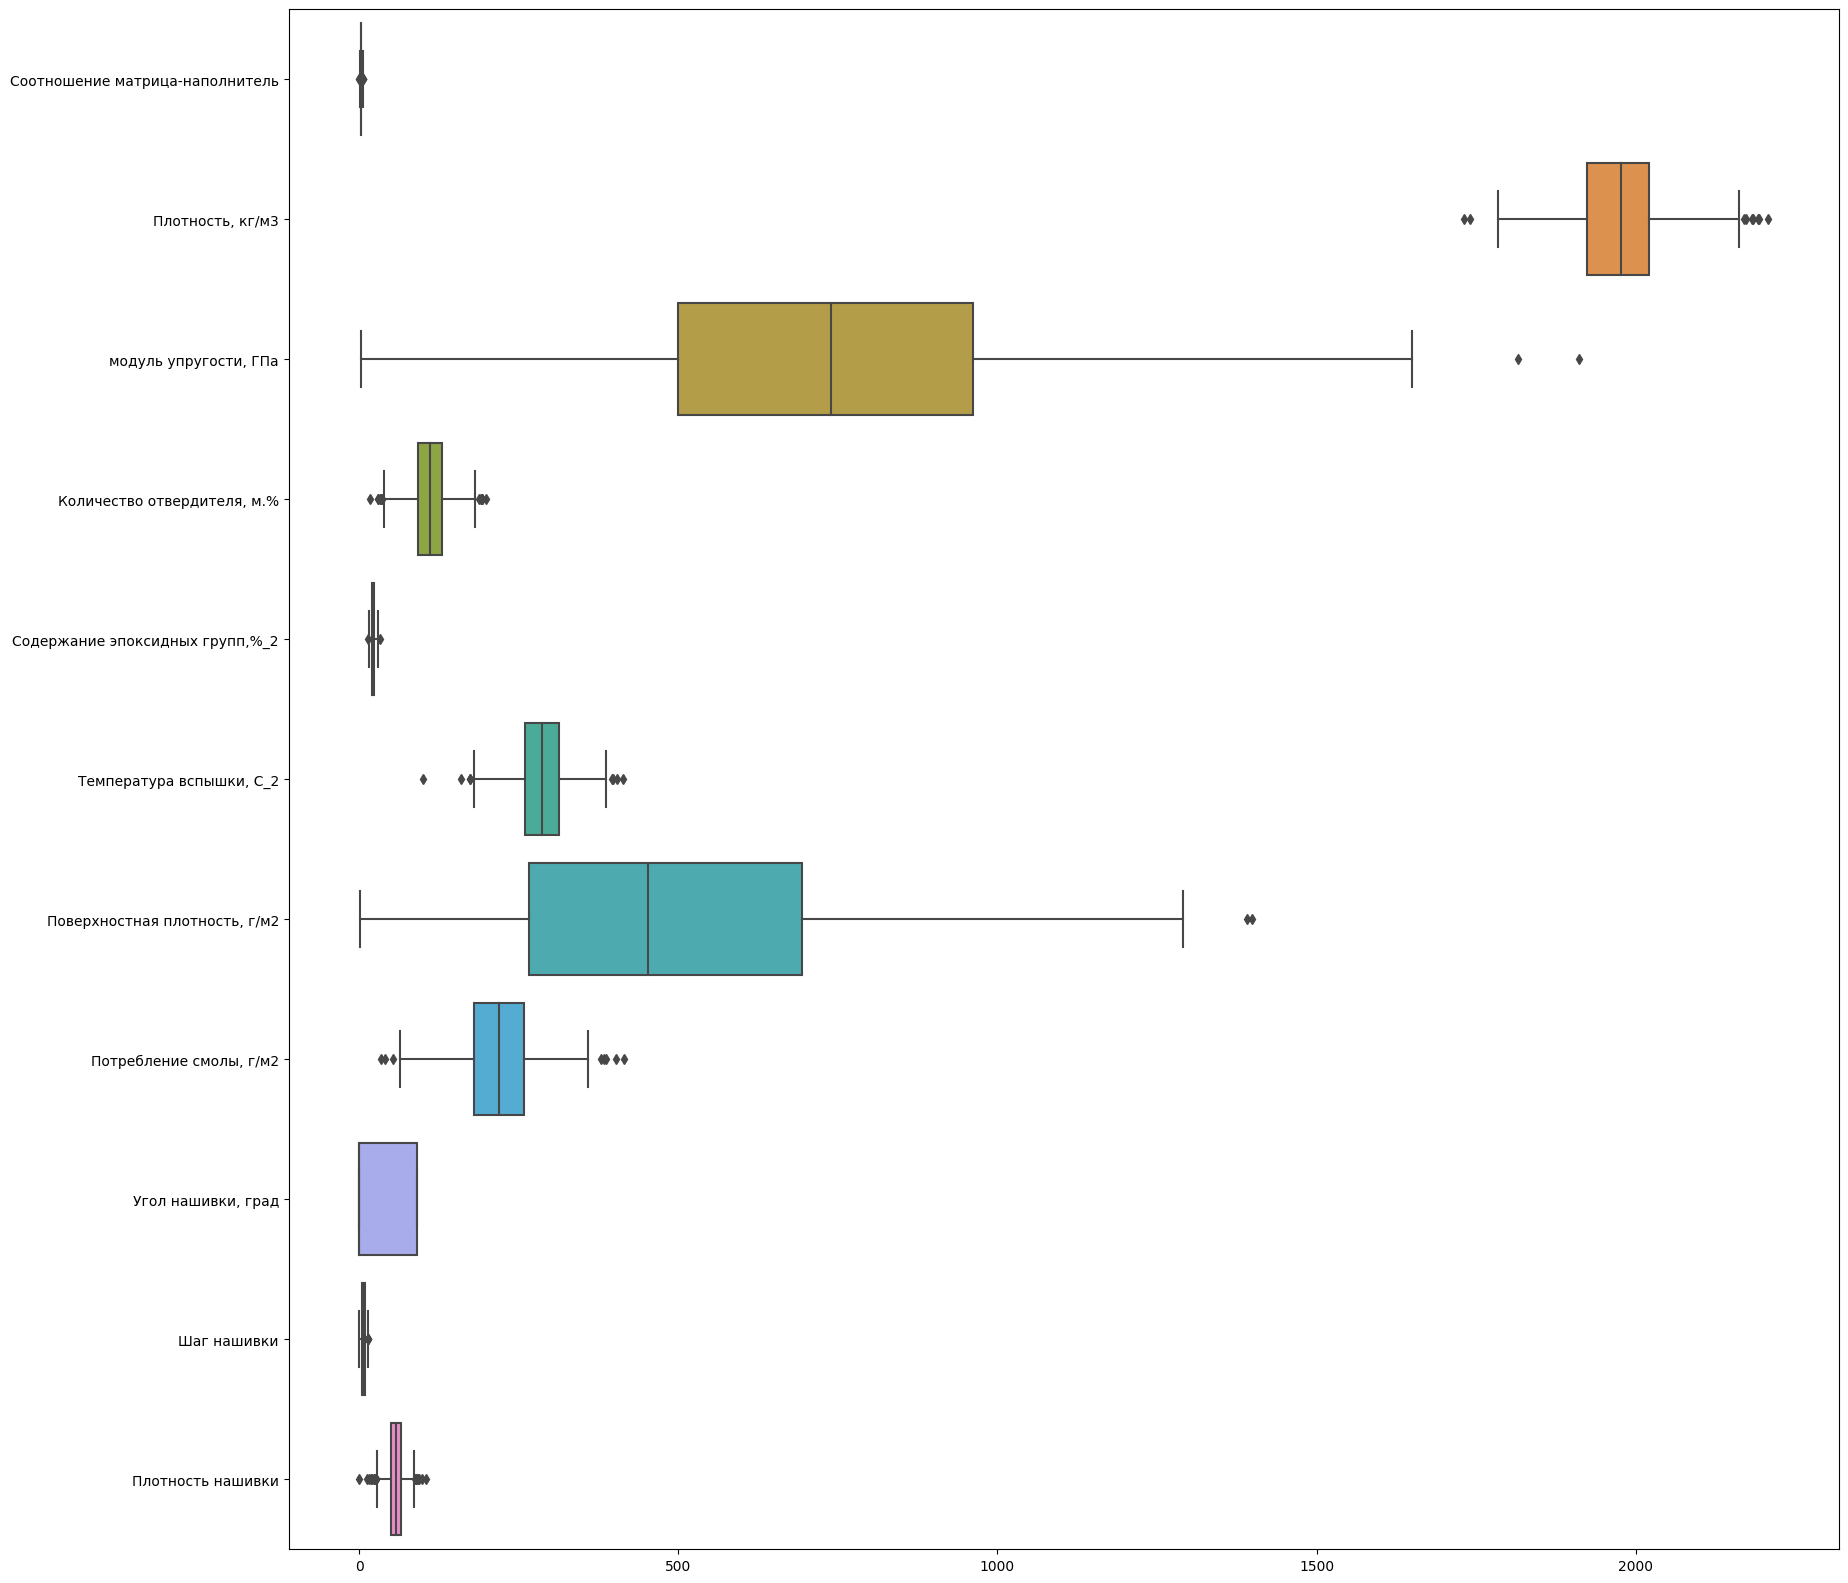

<Axes: >

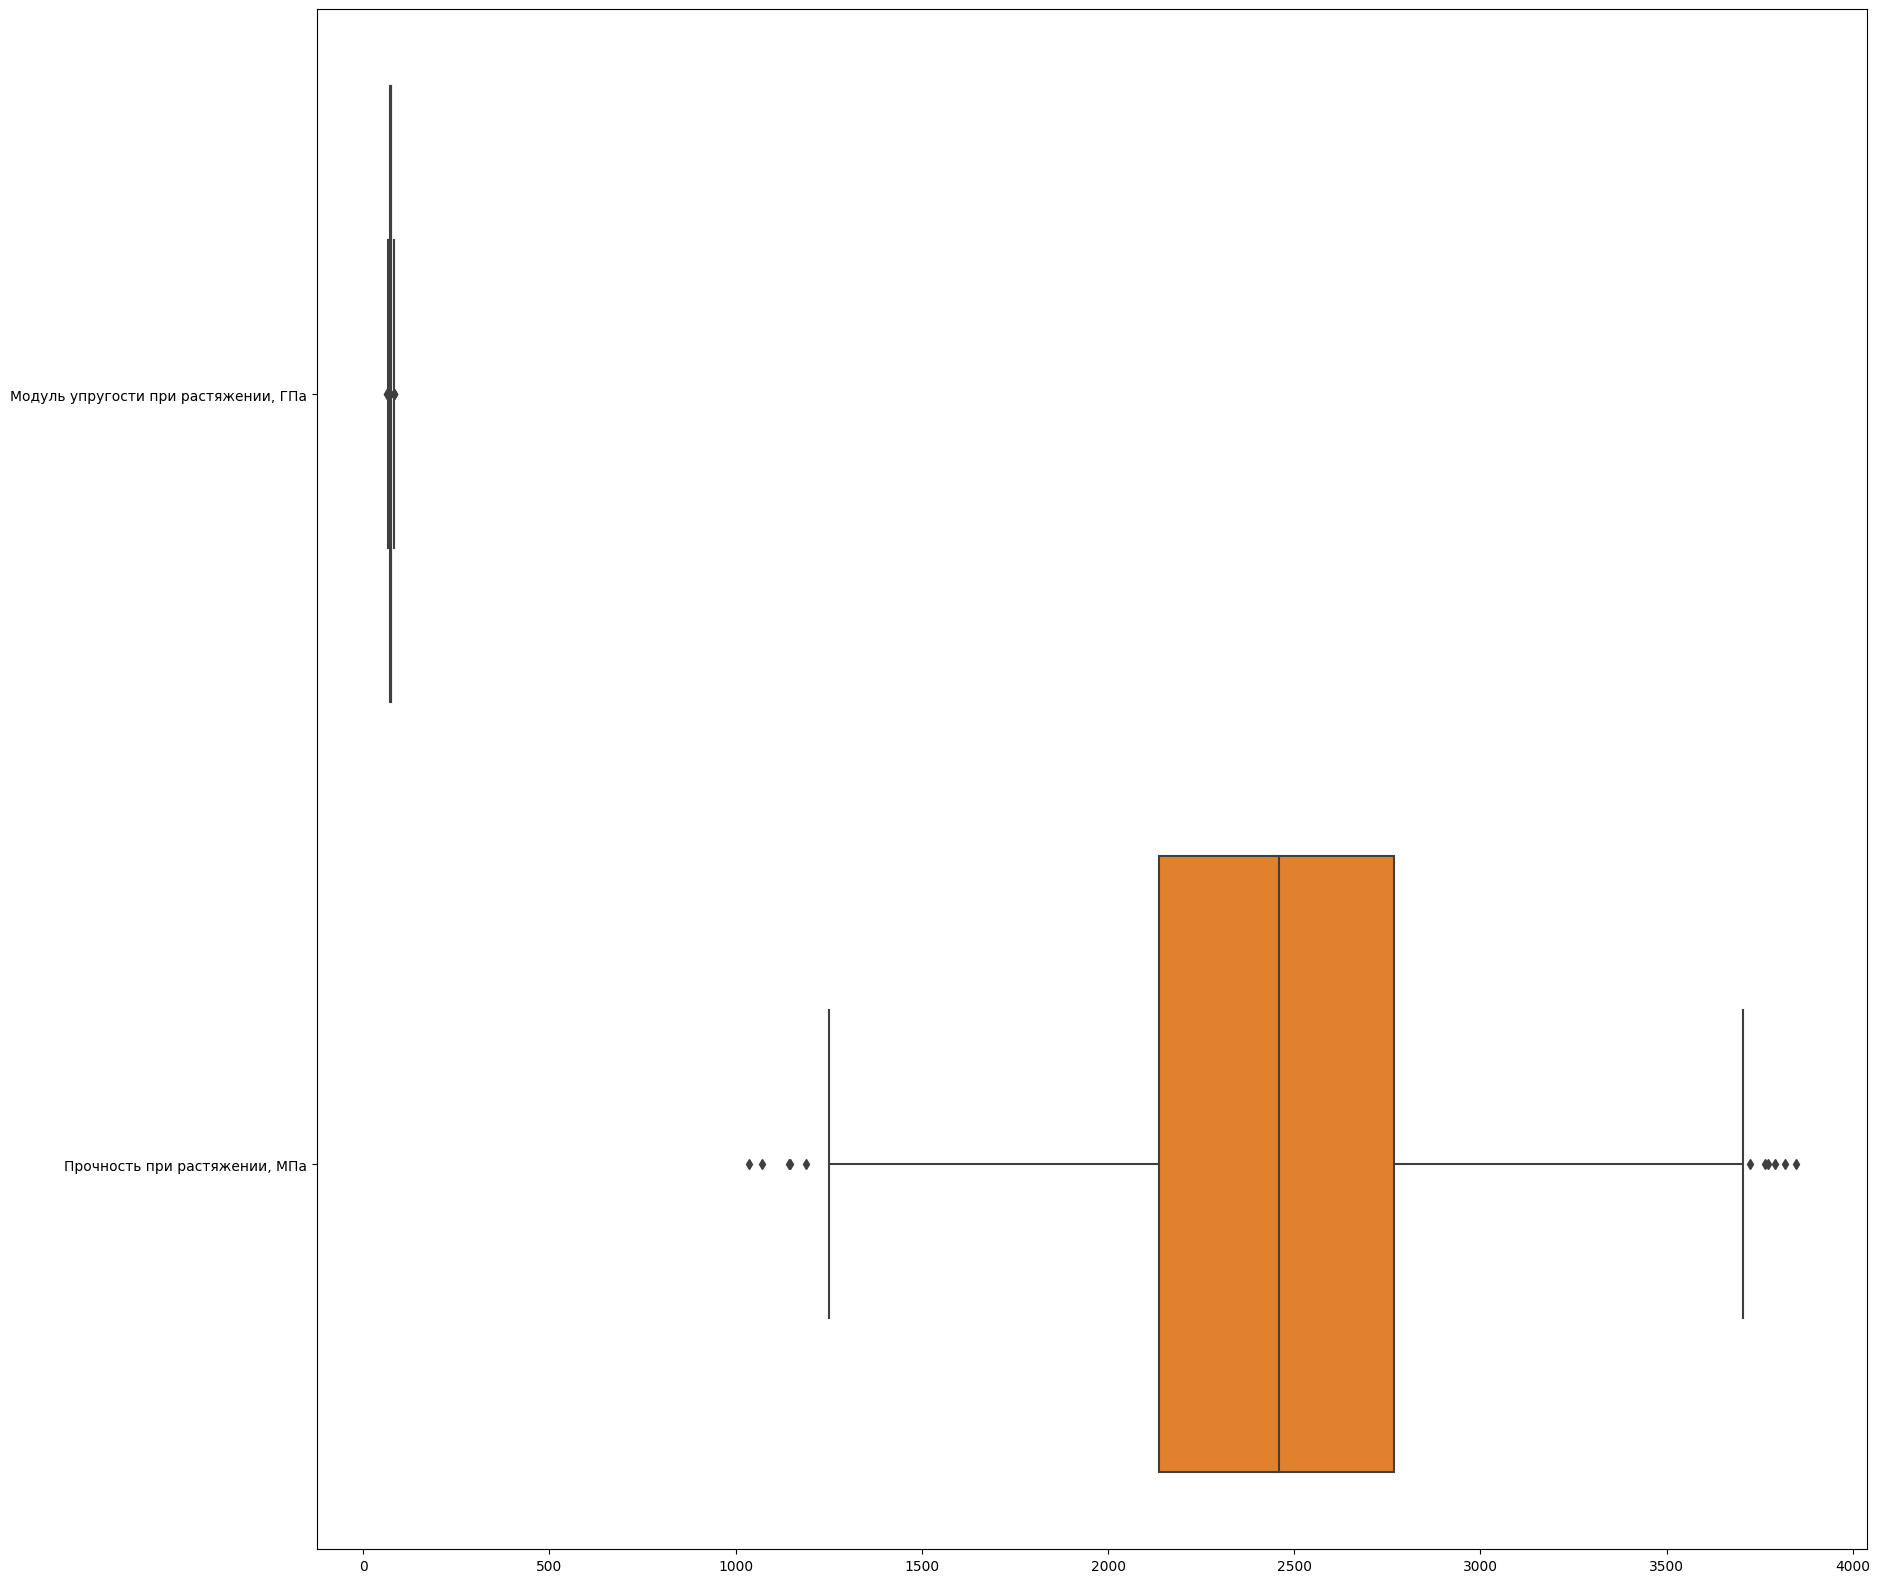

In [11]:
# также рассмотрим box-plot для входных признаков и выходных значений
fig = plt.figure(figsize=(20, 20))
sns.boxplot(data=X, orient='h')
plt.show()

fig = plt.figure(figsize=(20, 20))
sns.boxplot(data=y, orient='h')
plt.show()

### Вывод

Мы можем наблюдать отсутствие корреляции между признаками входного вектора. Также мы не видим ее между входыми значениями и целевыми показателями. Мы можем видеть выбросы на box-plot-ах и очень большой разброс масштаба у разных показателей, как входных, так и выходных. Необходимо выполнить нормализацию.

In [12]:
# выполним нормализацию
# можно выбрать какую нормализацию именно сделать - [min/max] или [mean/std]
# x_scaler = preprocessing.MinMaxScaler().fit(np.array(X))
# y_scaler = preprocessing.MinMaxScaler().fit(np.array(y))
x_scaler = preprocessing.StandardScaler().fit(np.array(X))
y_scaler = preprocessing.StandardScaler().fit(np.array(y))
X = pd.DataFrame(x_scaler.transform(np.array(X)), columns=X.columns)
y = pd.DataFrame(y_scaler.transform(np.array(y)), columns=y.columns)
# посмотрим на данные после нормализации
X.head()
X.describe().T.round(2)
y.head()
y.describe().T.round(2)

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа   
0                        -1.175779          0.736365              -0.003594  \
1                        -1.175779          0.736365              -0.003594   
2                        -1.175779          0.736365              -0.003594   
3                        -1.175779          0.736365              -0.003594   
4                        -0.174232          0.736365               0.039618   

   Количество отвердителя, м.%  Содержание эпоксидных групп,%_2   
0                    -2.848828                         0.009757  \
1                    -2.141666                         0.626001   
2                    -2.145202                         4.471955   
3                     0.651622                        -0.413446   
4                     0.045585                         0.009757   

   Температура вспышки, С_2  Поверхностная плотность, г/м2   
0                 -4.542215                      -0.969964  \
1                 -0.030955                      -0.969964   
2                 -0.030955                      -0.969964   
3                  0.344984                      -0.969964   
4                 -0.030955                      -0.969964   

   Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  Плотность нашивки  
0                  0.02641           -0.983518    -1.131530          -0.012469  
1                  0.02641           -0.983518    -1.131530           0.230546  
2                  0.02641           -0.983518    -1.131530           1.040595  
3                  0.02641           -0.983518    -0.741243          -0.822518  
4                  0.02641           -0.983518    -0.741243          -0.012469

count  mean  std   min   25%   50%   75%   
Соотношение матрица-наполнитель  1023.0  -0.0  1.0 -2.78 -0.67 -0.03  0.68  \
Плотность, кг/м3                 1023.0   0.0  1.0 -3.31 -0.70  0.03  0.62   
модуль упругости, ГПа            1023.0   0.0  1.0 -2.23 -0.73 -0.00  0.67   
Количество отвердителя, м.%      1023.0  -0.0  1.0 -3.28 -0.64 -0.00  0.68   
Содержание эпоксидных групп,%_2  1023.0  -0.0  1.0 -3.32 -0.68 -0.01  0.71   
Температура вспышки, С_2         1023.0   0.0  1.0 -4.54 -0.66  0.00  0.66   
Поверхностная плотность, г/м2    1023.0   0.0  1.0 -1.71 -0.77 -0.11  0.75   
Потребление смолы, г/м2          1023.0  -0.0  1.0 -3.09 -0.65  0.01  0.65   
Угол нашивки, град               1023.0   0.0  1.0 -0.98 -0.98 -0.98  1.02   
Шаг нашивки                      1023.0  -0.0  1.0 -2.69 -0.71  0.01  0.66   
Плотность нашивки                1023.0   0.0  1.0 -4.63 -0.60  0.02  0.63   

                                  max  
Соотношение матрица-наполнитель  2.92  
Плотность, кг/м3                 3.15  
модуль упругости, ГПа            3.55  
Количество отвердителя, м.%      3.13  
Содержание эпоксидных групп,%_2  4.47  
Температура вспышки, С_2         3.11  
Поверхностная плотность, г/м2    3.26  
Потребление смолы, г/м2          3.29  
Угол нашивки, град               1.02  
Шаг нашивки                      2.94  
Плотность нашивки                3.79

Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа
0                              -1.06772                       1.098244
1                              -1.06772                       1.098244
2                              -1.06772                       1.098244
3                              -1.06772                       1.098244
4                              -1.06772                       1.098244

count  mean  std   min   25%   50%   
Модуль упругости при растяжении, ГПа  1023.0  -0.0  1.0 -2.98 -0.67 -0.02  \
Прочность при растяжении, МПа         1023.0   0.0  1.0 -2.95 -0.68 -0.02   

                                       75%   max  
Модуль упругости при растяжении, ГПа  0.65  3.00  
Прочность при растяжении, МПа         0.62  2.85

In [13]:
# удаление выбросов методом межквартильных расстояний, берет 25% и 75% перцентили
ds = pd.DataFrame(
    np.concatenate([np.array(X), np.array(y)], axis=1),
    columns=[*X.columns, *y.columns]
)
outliers = len(ds)
for i in ds.columns:
    q75, q25 = np.percentile(ds.loc[:, i], [75, 25])
    intr_qr = q75 - q25
    max = q75 + (1.5 * intr_qr)
    min = q25 - (1.5 * intr_qr)
    ds.loc[ds[i] < min, i] = np.nan
    ds.loc[ds[i] > max, i] = np.nan
ds.dropna(inplace=True)
outliers = outliers - len(ds)
print(f'Количество удаленных выбросов: {outliers}')
assert X.shape[0] == y.shape[0]
print(f'Количество оставшихся дата-кейсов: {X.shape[0]}')

Количество удаленных выбросов: 87
Количество оставшихся дата-кейсов: 1023


In [14]:
# переформируем вектора признаков и целевых показателей
y = ds[y_labels]
X = ds.drop(y_labels, axis=1)
# проверим, что количество элементов входа соответствует количеству элементов выхода
assert X.shape[0] == y.shape[0]

<Axes: >

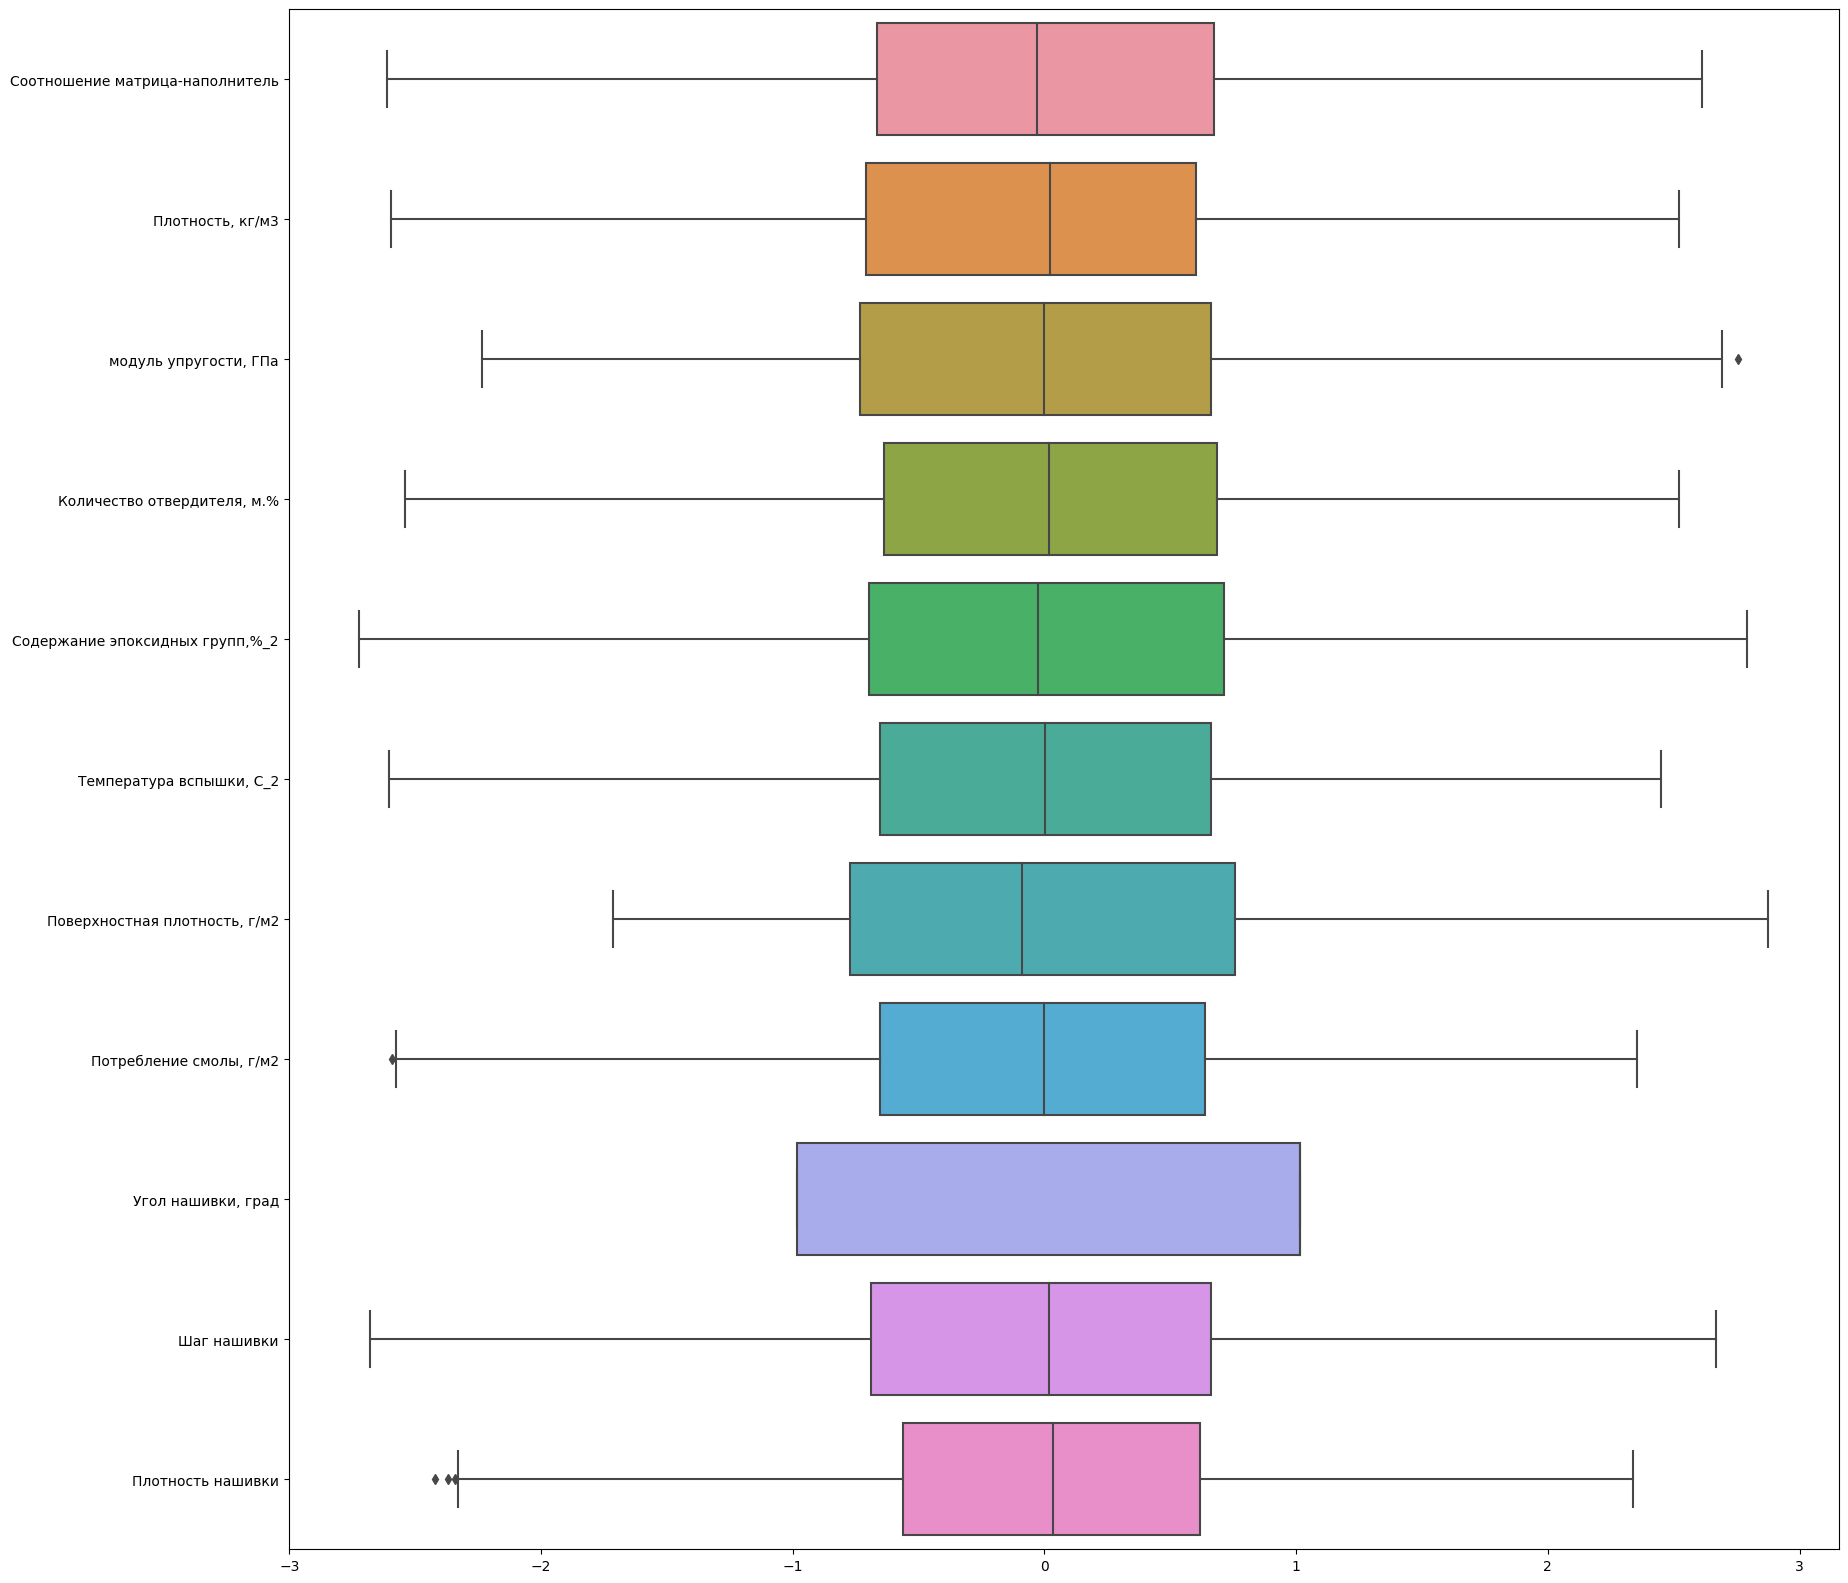

<Axes: >

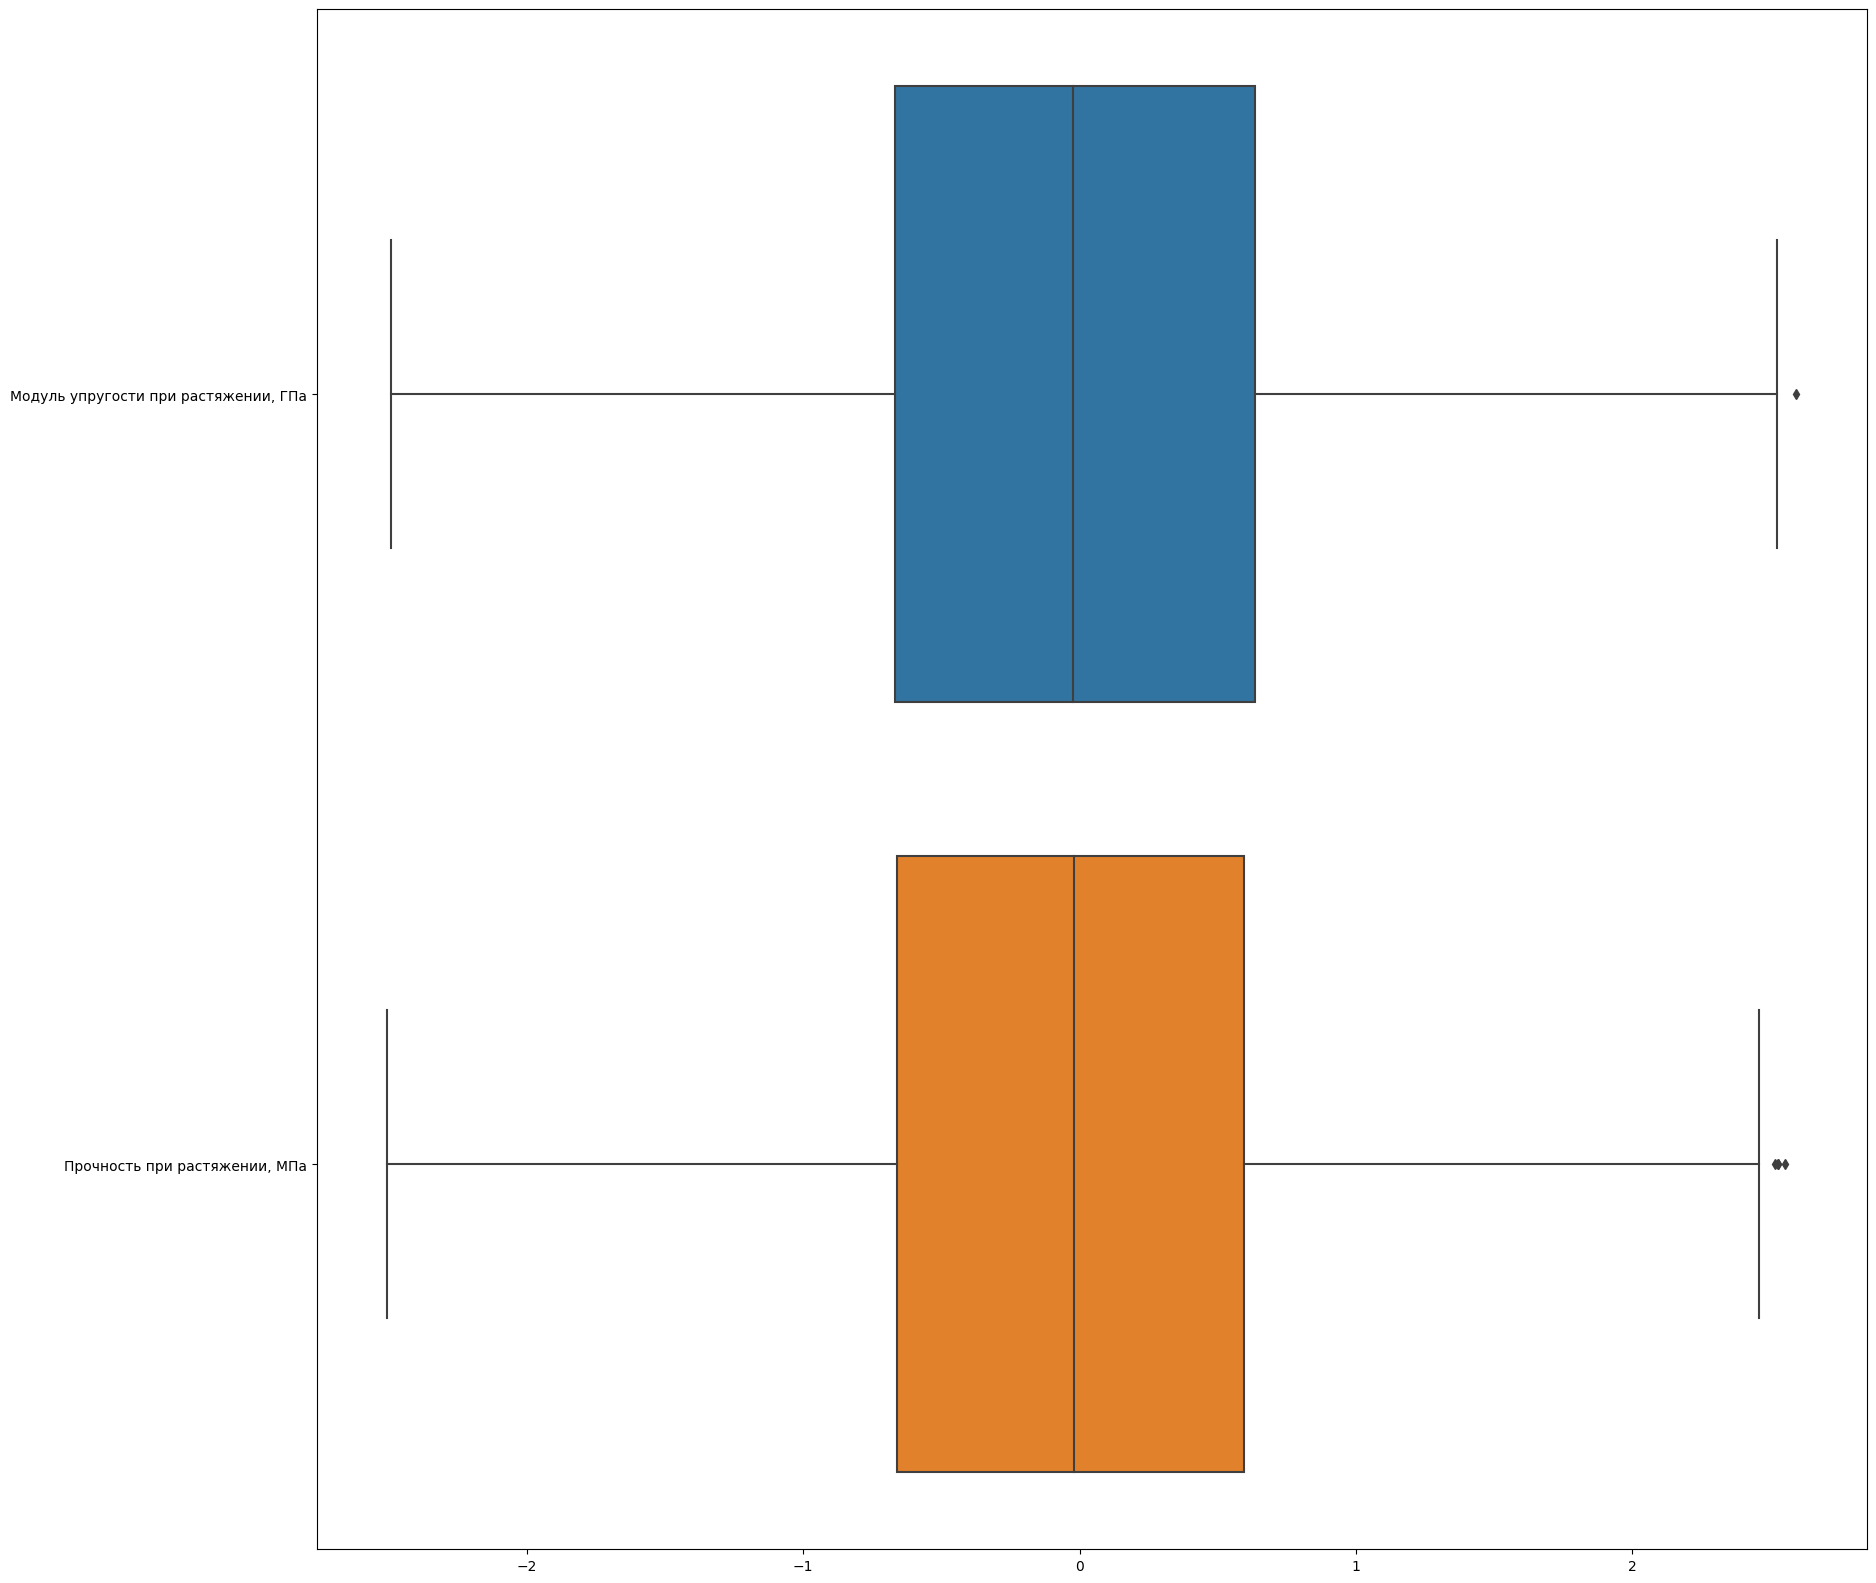

In [15]:
# также рассмотрим box-plot для входных признаков и выходных значений после нормализации
fig = plt.figure(figsize=(20, 20))
sns.boxplot(data=X, orient='h')
plt.show()

fig = plt.figure(figsize=(20, 20))
sns.boxplot(data=y, orient='h')
plt.show()

<Axes: ylabel='Density'>

<Axes: ylabel='Density'>

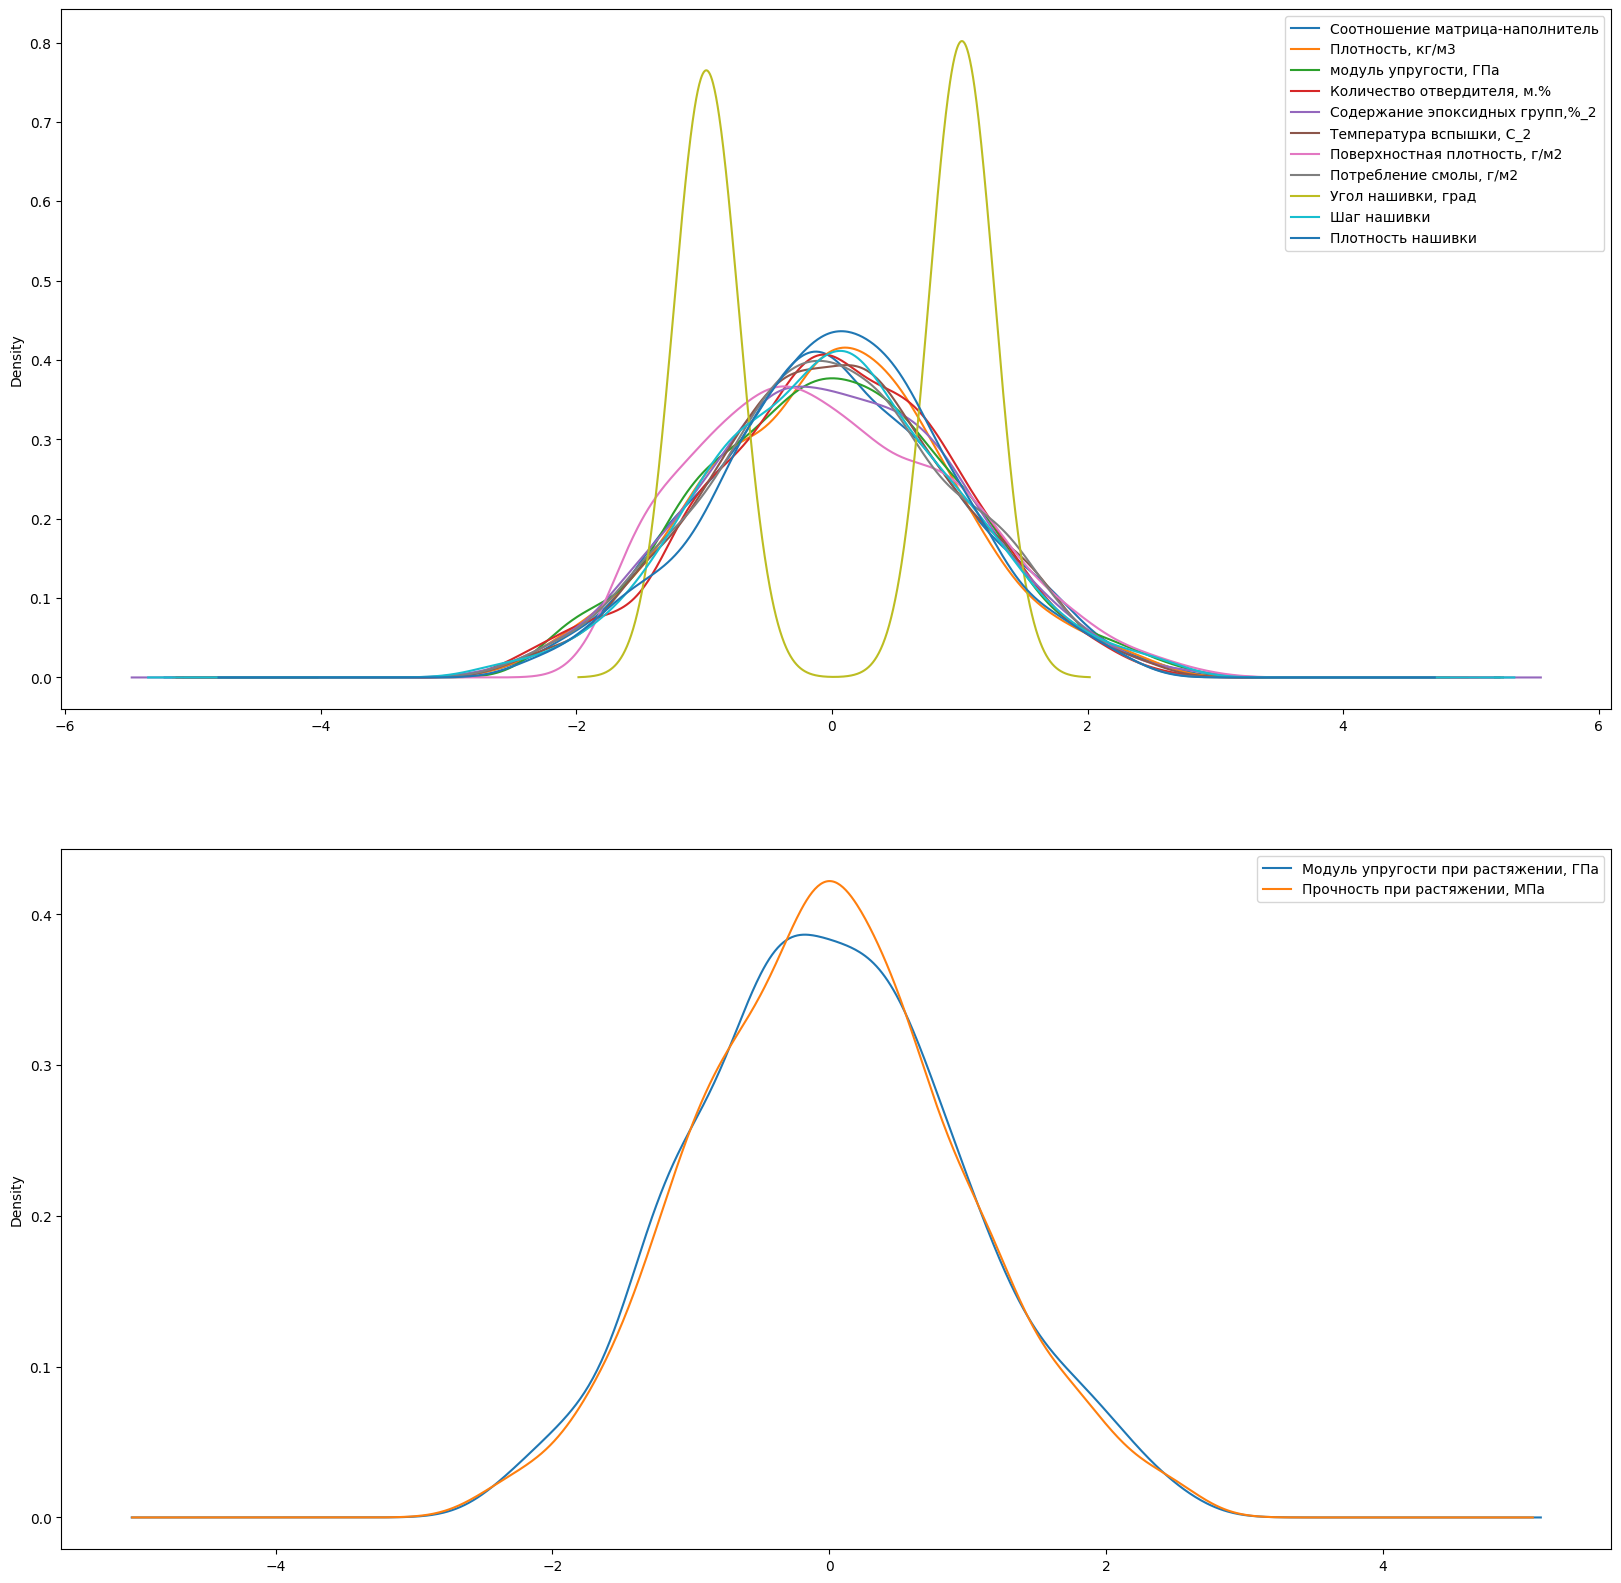

In [16]:
# оценим плотность ядра признаков и целевых значений
fig, ax = plt.subplots(2, 1, figsize=(20, 20))
X.plot(kind='kde', ax=ax[0])
y.plot(kind='kde', ax=ax[1])

<Axes: >

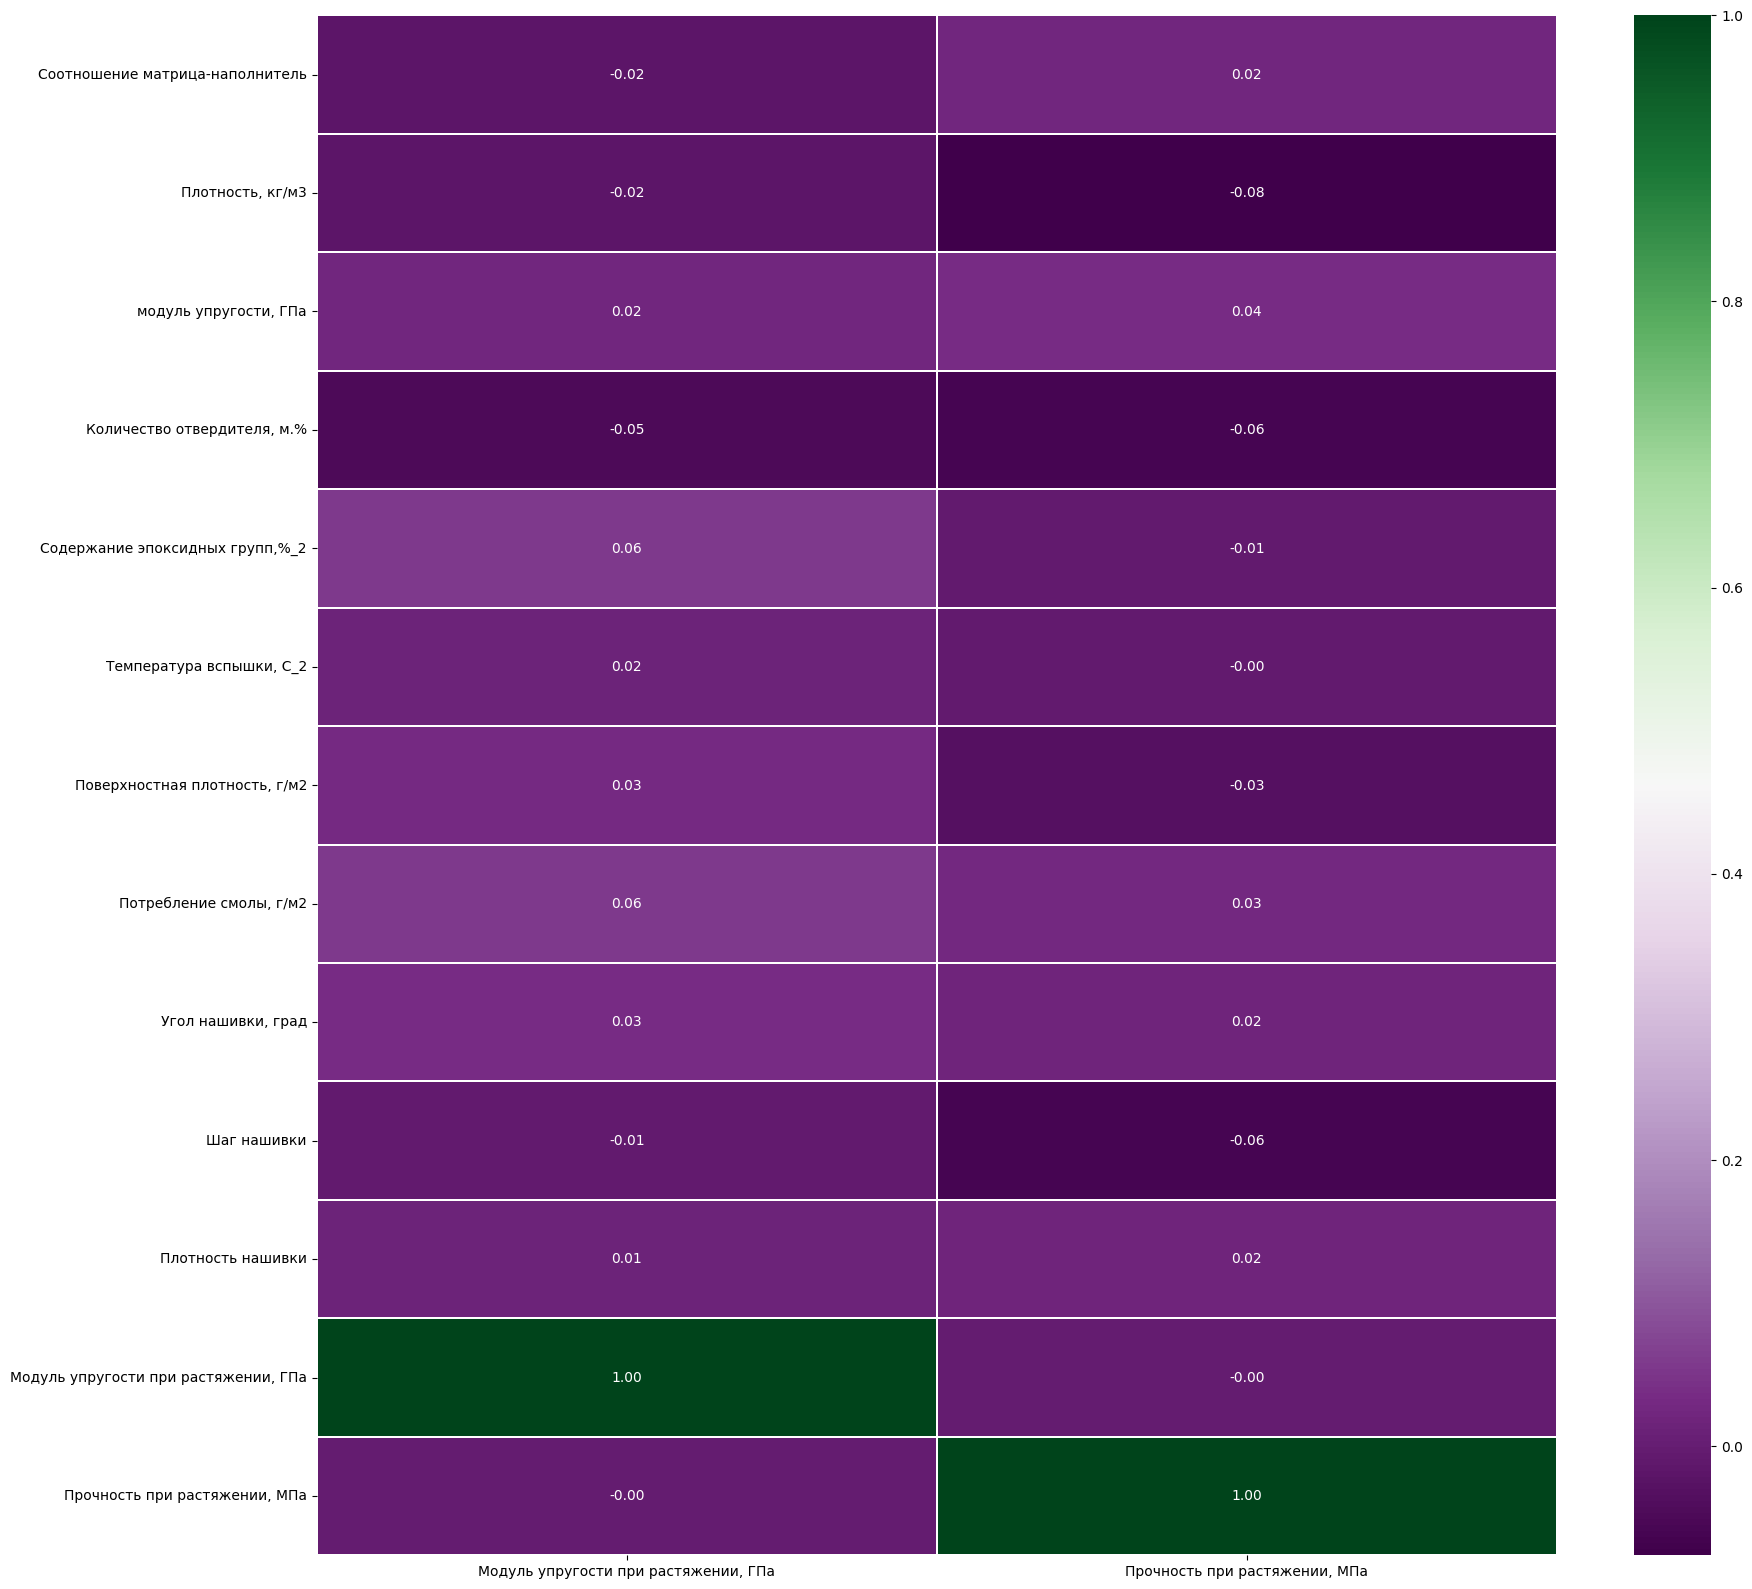

In [17]:
# рассмотрим матрицу корреляции между входными и выходными значениями после нормализации
corr = ds.corr()
corr = corr[y_labels]
fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f',cmap='PRGn', linewidths=0.1)
plt.show()

### Вывод

Мы провели анализ данных. Избавились от выбросов, сделали нормализации. Мы готовы обучать.

### Обучение

In [18]:
# разделим датасет на данные для обучения и данные для тестирования
X_train, X_test, y_train,y_test = train_test_split(X, y , test_size=0.3, random_state=42)
print(f'Размер датасета для обучения: {len(X_train)}')
print(f'Размер датасета для тестирования: {len(X_test)}')

Размер датасета для обучения: 655
Размер датасета для тестирования: 281


In [19]:
# будем сохранять результаты обучения
train_log = {
    'model_name': [],
    'model': [],
    'mse': [],
    'r2': []
}

In [20]:
#Визуализация предсказанных значений целевых переменных
def show_pred_plot(y_test, y_pred, model_name, y_labels):
    for lb_i, lb in enumerate(y_labels):
      plt.figure(figsize=(15, 9))
      plt.title(f'Целевой признак: {lb}, Модель: {model_name}')
      plt.plot(y_test.to_numpy()[:, lb_i], label='Тест')
      plt.plot(y_pred[:, lb_i], label='Прогноз')
      plt.legend(loc='best')
      plt.ylabel('н')
      plt.xlabel('Порядок')

LinearRegression()

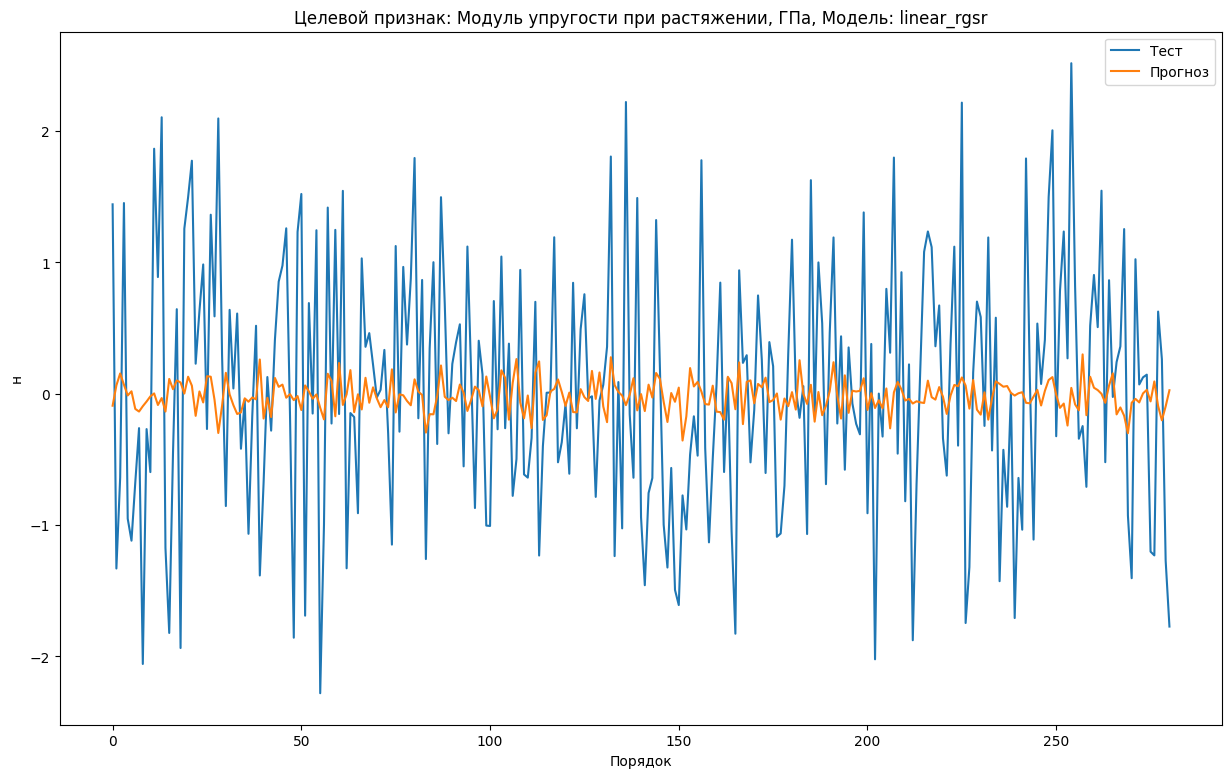

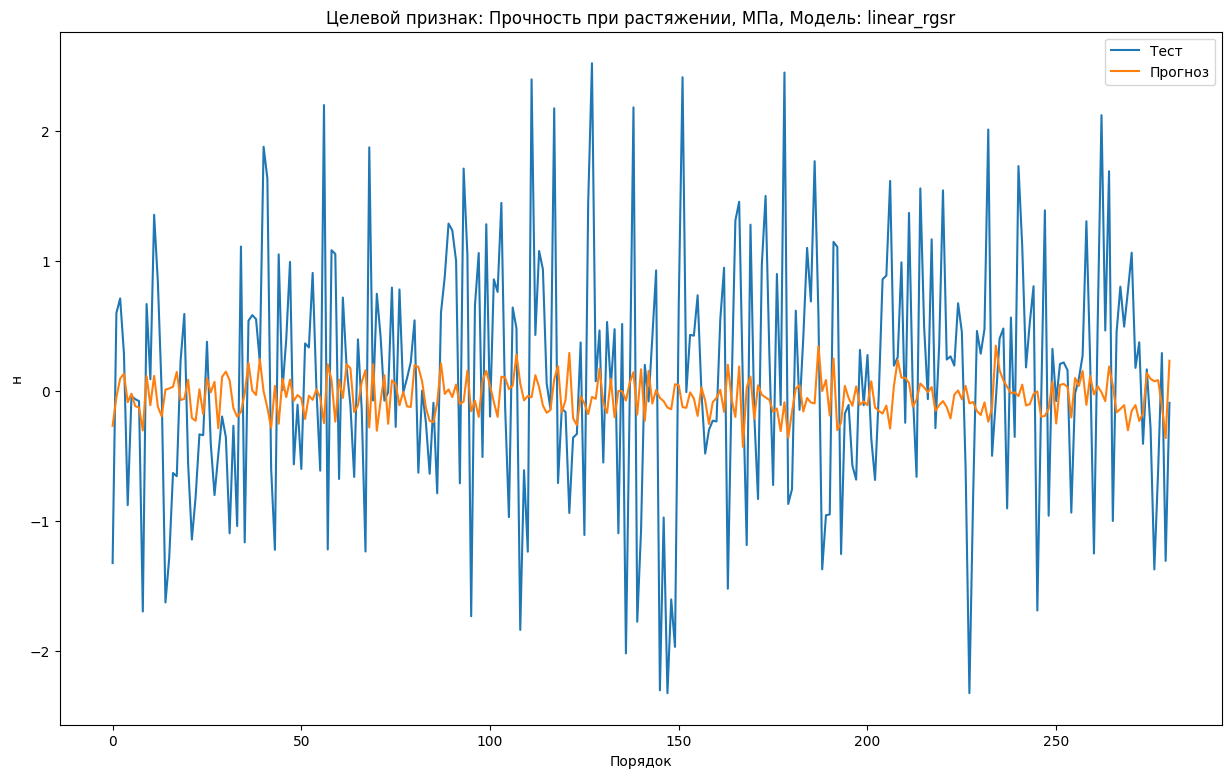

In [21]:
# обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# посчитаем ошибку
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
train_log['model_name'].append('linear_rgsr')
train_log['model'].append(model)
train_log['mse'].append(mse)
train_log['r2'].append(r2)

# отрисуем график предсказание-истина по всем кейсам
show_pred_plot(y_test, y_pred, train_log['model_name'][-1], y_labels)

Fitting 10 folds for each of 800 candidates, totalling 8000 fits


GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': range(1, 101),
                         'weights': ['uniform', 'distance']},
             verbose=1)

KNeighborsRegressor(n_neighbors=100)

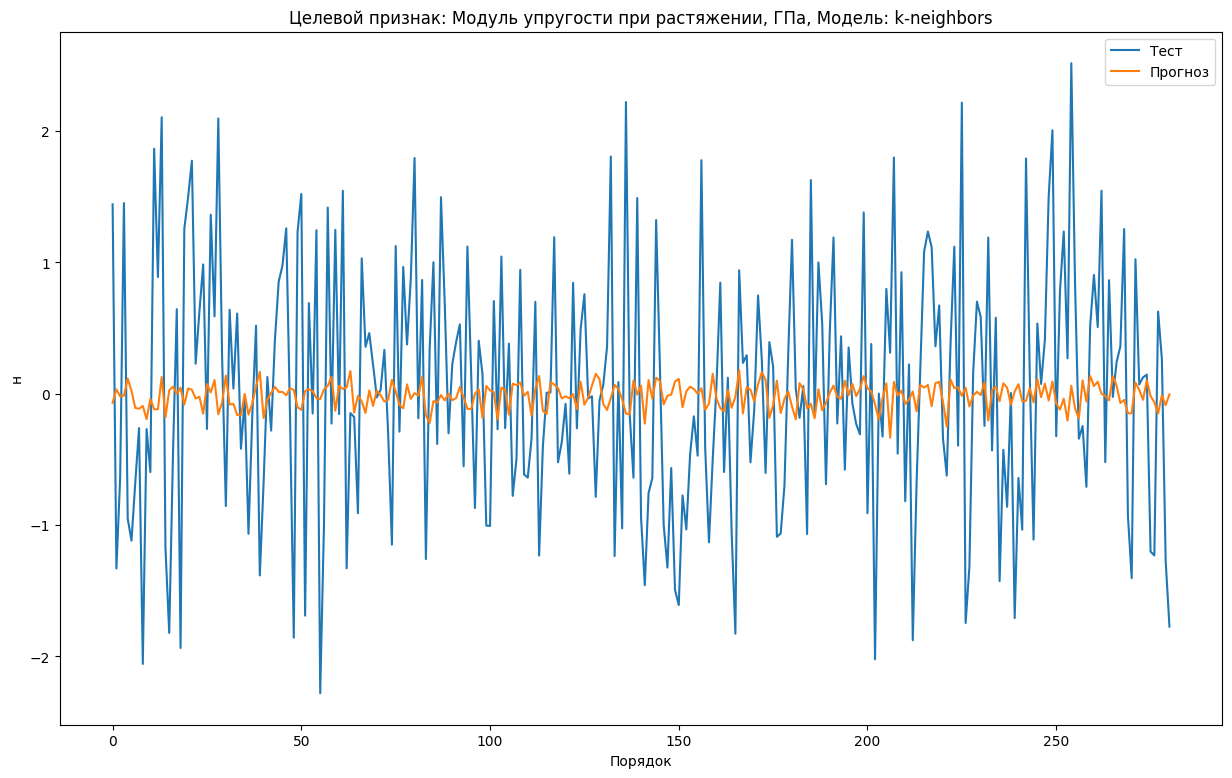

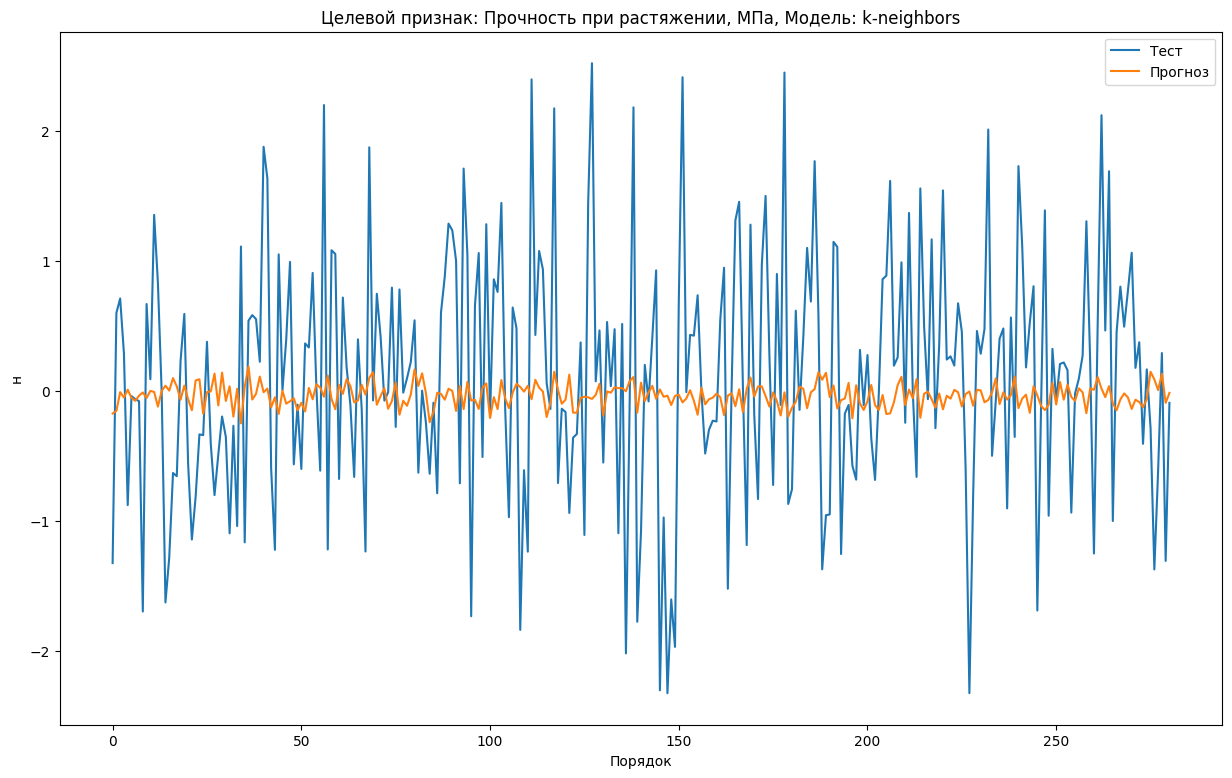

In [ ]:
# K-ближайших соседей
# запускаем поиск по сетке параметров, выбираем лучший вариант
model = KNeighborsRegressor()
grid = {'n_neighbors' : range(1, 101, 1), 
        'weights' : ['uniform', 'distance'],
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
gsc = GridSearchCV(model, grid, n_jobs=-1, cv=10, verbose=1)
gsc.fit(X_train,  y_train)
model = gsc.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# посчитаем ошибку
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
train_log['model_name'].append('k-neighbors')
train_log['model'].append(model)
train_log['mse'].append(mse)
train_log['r2'].append(r2)

# отрисуем график предсказание-истина по всем кейсам
show_pred_plot(y_test, y_pred, train_log['model_name'][-1], y_labels)

GridSearchCV(cv=10, estimator=MultiOutputRegressor(estimator=SVR()), n_jobs=-1,
             param_grid={'estimator__C': array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
                         'estimator__epsilon': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

MultiOutputRegressor(estimator=SVR(epsilon=0.9))

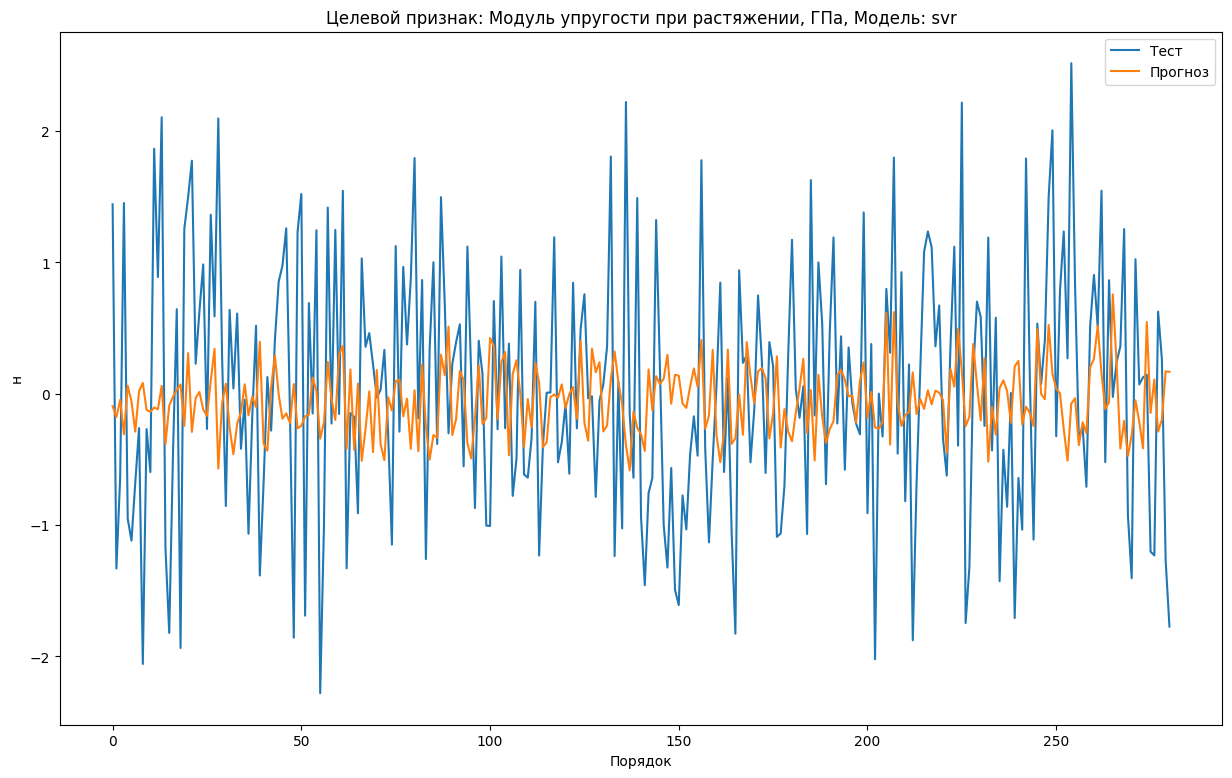

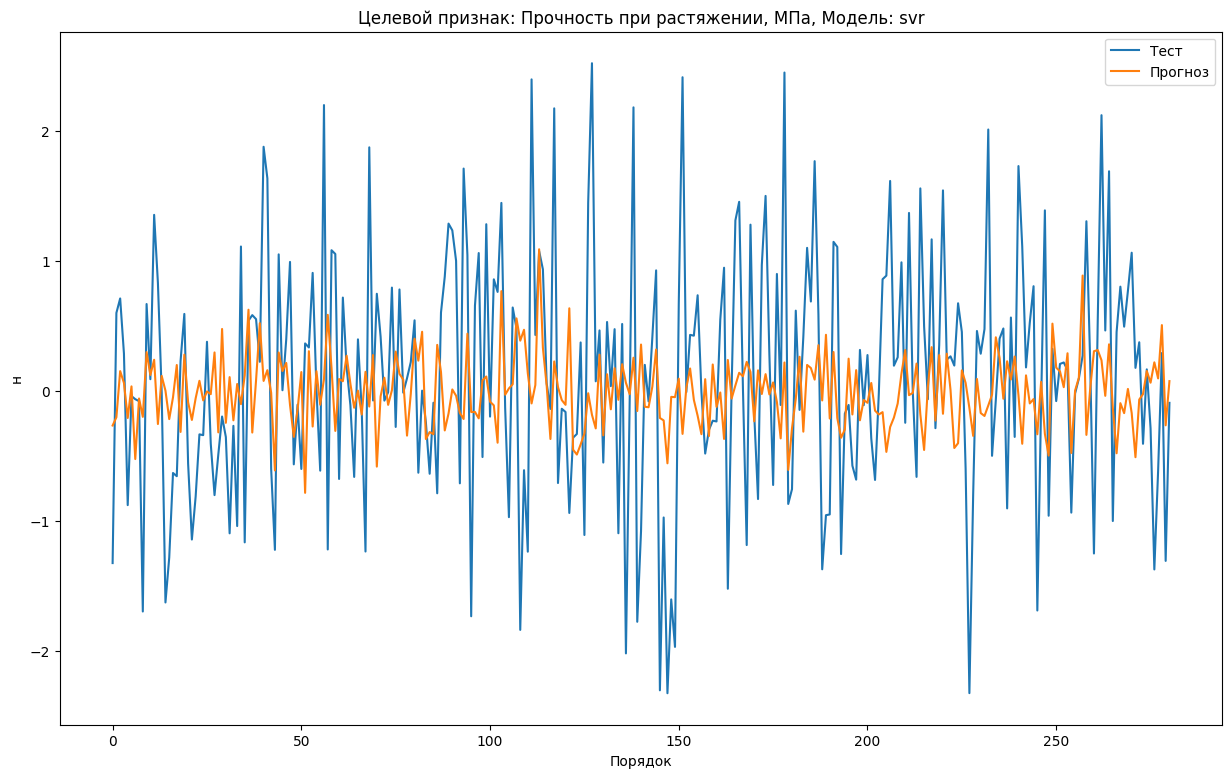

In [23]:
# Метод опорных векторов, также поиск по сетке
grid = {
    'estimator__C':np.arange(1.0,5.5,0.5),
    'estimator__epsilon':np.arange(0.1,1.1,0.1)
}

model = MultiOutputRegressor(SVR())
gsc = GridSearchCV(model, grid, n_jobs=-1, cv=10)
gsc.fit(X_train, y_train)
model = gsc.best_estimator_
model.fit(X_train,  y_train)
y_pred = model.predict(X_test)

# посчитаем ошибку
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
train_log['model_name'].append('svr')
train_log['model'].append(model)
train_log['mse'].append(mse)
train_log['r2'].append(r2)

# отрисуем график предсказание-истина по всем кейсам
show_pred_plot(y_test, y_pred, train_log['model_name'][-1], y_labels)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=14), n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': range(1, 5),
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': range(1, 100, 5)})

RandomForestRegressor(max_depth=1, max_features='sqrt', n_estimators=81,
                      random_state=14)

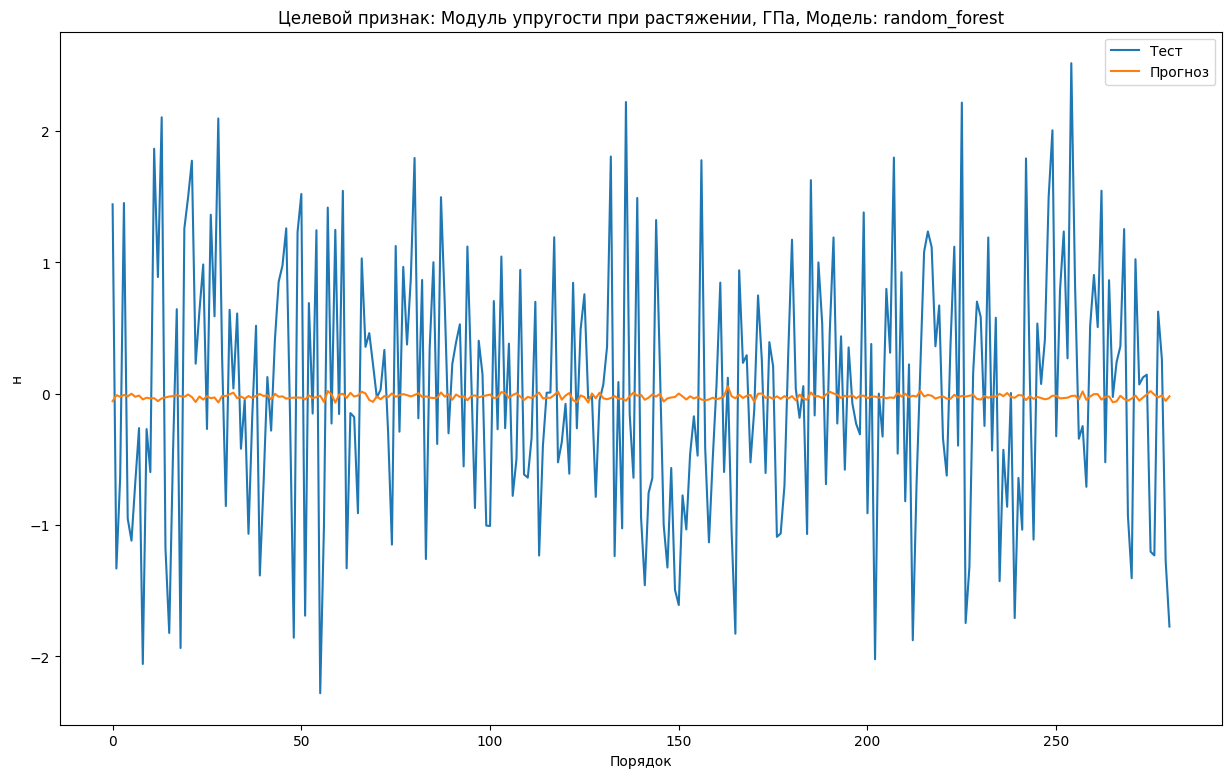

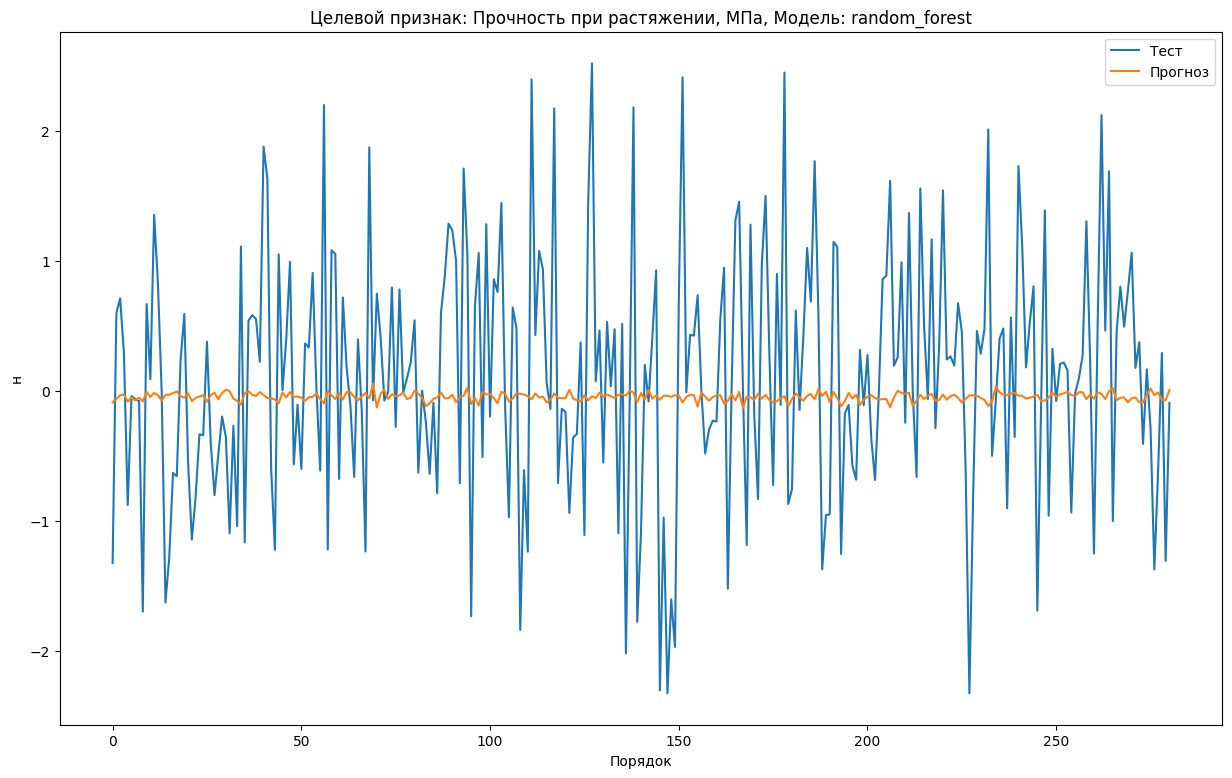

In [24]:
# Случайный лес
model = RandomForestRegressor(random_state=14)
grid = {
    'n_estimators' : range(1, 100, 5),
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth' : range(1, 5, 1),
    'criterion':['squared_error']
}
gsc = MultiOutputRegressor(model)
gsc = GridSearchCV(model, grid, n_jobs=-1, cv=10)
gsc.fit(X_train,  y_train)
model = gsc.best_estimator_
model.fit(X_train,  y_train)
y_pred = model.predict(X_test)

# посчитаем ошибку
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
train_log['model_name'].append('random_forest')
train_log['model'].append(model)
train_log['mse'].append(mse)
train_log['r2'].append(r2)

# отрисуем график предсказание-истина по всем кейсам
show_pred_plot(y_test, y_pred, train_log['model_name'][-1], y_labels)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               3

17/17 [==============================] - 0s 3ms/step - loss: 0.3036 - mae: 0.4294 - mse: 0.3036 - val_loss: 1.1908 - val_mae: 0.8796 - val_mse: 1.1908
Epoch 88/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3158 - mae: 0.4445 - mse: 0.3158 - val_loss: 1.2006 - val_mae: 0.8802 - val_mse: 1.2006
Epoch 89/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3046 - mae: 0.4401 - mse: 0.3046 - val_loss: 1.1977 - val_mae: 0.8771 - val_mse: 1.1977
Epoch 90/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3434 - mae: 0.4523 - mse: 0.3434 - val_loss: 1.2202 - val_mae: 0.8917 - val_mse: 1.2202
Epoch 91/100
17/17 [==============================] - 0s 3ms/step - loss: 0.2953 - mae: 0.4304 - mse: 0.2953 - val_loss: 1.2227 - val_mae: 0.8915 - val_mse: 1.2227
Epoch 92/100
17/17 [==============================] - 0s 3ms/step - loss: 0.3037 - mae: 0.4307 - mse: 0.3037 - val_loss: 1.2125 - val_mae: 0.8904 - val_mse: 1.2125
Epoch 93/100
17/17 [=========

Text(0.5, 0, 'Эпоха')

Text(0, 0.5, 'Loss')

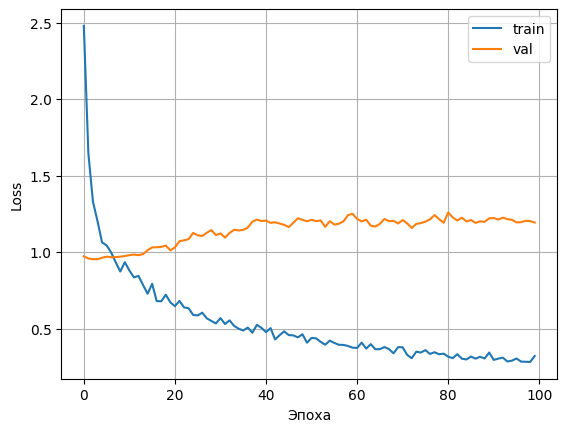

In [25]:
# Нейронная сеть
layers_list = [
    layers.Dense(64, input_dim=X.shape[1], activation='relu'),
    layers.BatchNormalization()
]
dp_rate = 0.1
for h_dim in [128, 256, 64]:
    layers_list.extend([
        layers.Dense(h_dim, activation='relu'),
        layers.Dropout(dp_rate),
        layers.BatchNormalization()
    ])
layers_list.append(layers.Dense(y.shape[1]))
model = keras.Sequential(layers_list)
model.summary()
dfmodel = model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
history = model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    verbose=1, epochs=100, validation_split=0.2
)

# график целевой функции в процессе обучения
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

9/9 [==============================] - 0s 990us/step


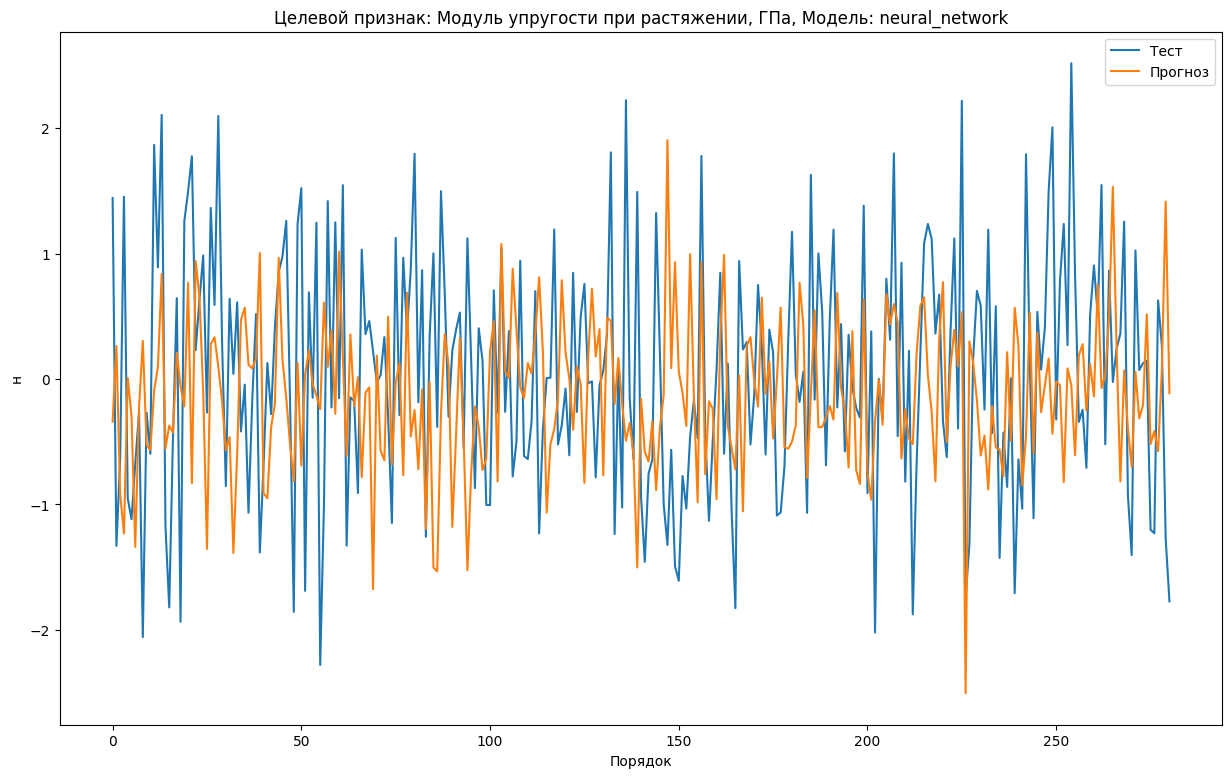

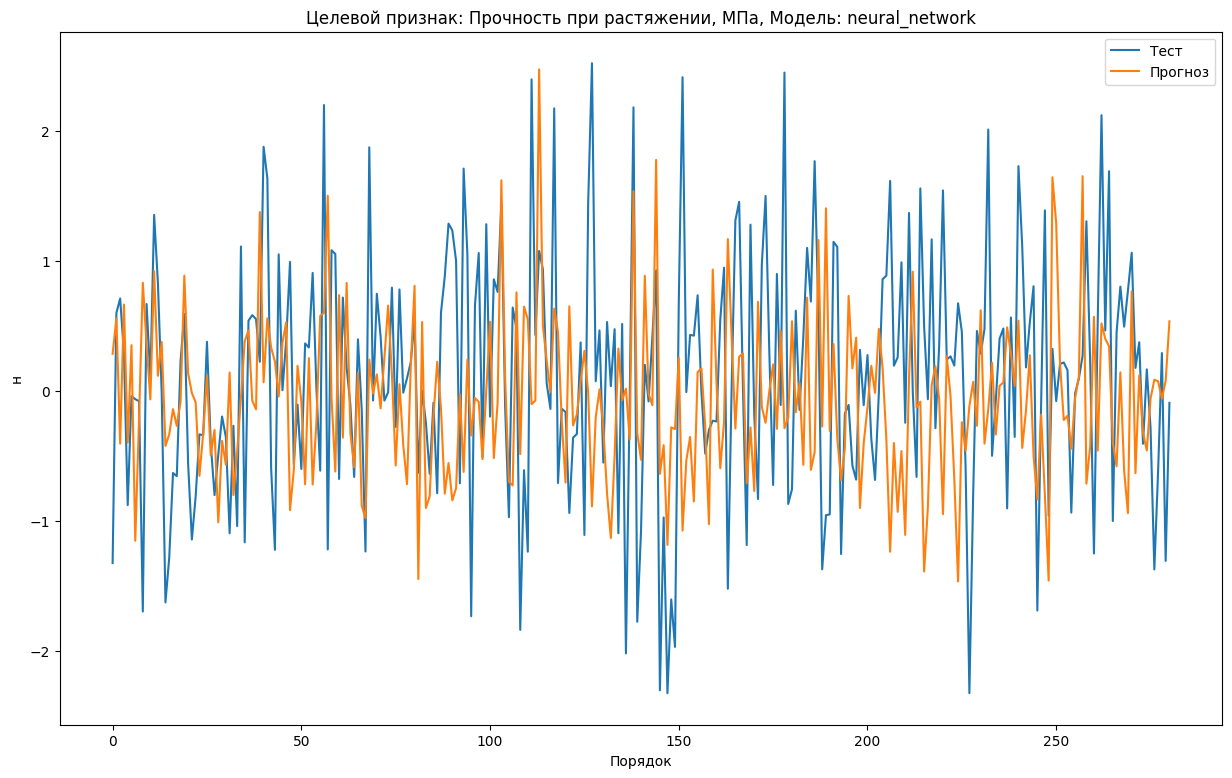

In [26]:
y_pred = model.predict(X_test)

# посчитаем ошибку
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
train_log['model_name'].append('neural_network')
train_log['model'].append(model)
train_log['mse'].append(mse)
train_log['r2'].append(r2)

# отрисуем график предсказание-истина по всем кейсам
show_pred_plot(y_test, y_pred, train_log['model_name'][-1], y_labels)

In [27]:
# Вывести результаты всех экспериментов
best_model_i = np.argmin(train_log['mse'])
best_model = train_log['model'][best_model_i]
best_mse = train_log['mse'][best_model_i]
best_model_name = train_log['model_name'][best_model_i]
for i in range(len(train_log['mse'])):
    exp_data = {k: v[i] for k, v in train_log.items()}
    print(f'Model: {exp_data["model_name"]}\t-\tMSE: {exp_data["mse"]:.4f}\t-\tR2: {exp_data["r2"]:.4f}')
print(f'Best model is: {best_model_name} with mse={best_mse:.4f}')

Model: linear_rgsr	-	MSE: 0.9028	-	R2: -0.0245
Model: k-neighbors	-	MSE: 0.9062	-	R2: -0.0284
Model: svr	-	MSE: 0.9251	-	R2: -0.0495
Model: random_forest	-	MSE: 0.8987	-	R2: -0.0197
Model: neural_network	-	MSE: 1.2175	-	R2: -0.3813
Best model is: random_forest with mse=0.8987


In [28]:
# сохраним лучшую модель и скейлер

from joblib import dump, load


dump(best_model, 'model.joblib')
dump(x_scaler, 'x_scaler.joblib')
dump(y_scaler, 'y_scaler.joblib')

['model.joblib']

['x_scaler.joblib']

['y_scaler.joblib']

In [1]:
# Имитируем загрузку и инференс

loaded_model = load('model.joblib') 
loaded_scaler_x = load('x_scaler.joblib')
loaded_scaler_y = load('y_scaler.joblib')

print(f'Пример входного вектора:\n{ex_x}')
print(f'Результат для примера входного вектора:\n{ex_y}')

print('Приложение прогнозирует значения модулей упругости и растяжения')
in_x = []
for x_name in X.columns:
    in_x.append(float(input(f'{x_name}: ')))
print('Выполняю предсказание...')
res = loaded_model.predict(
    loaded_scaler_x.transform(np.array(in_x)[None, ...])
)
res = loaded_scaler_y.inverse_transform(np.array(res))[0]
for i in range(len(res)):
    print(f'{y_labels[i]} = {res[i]}')

NameError: name 'load' is not defined

Приложение

In [ ]:
from joblib import dump, load
def input_variable():

  x1 = float(input('Введите значение переменной Соотношение матрица-наполнитель: '))
  x2 = float(input('Введите значение переменной Плотность: '))
  x3 = float(input('Введите значение переменной Модуль упругости: '))
  x4 = float(input('Введите значение переменной Количество отвердителя: '))
  x5 = float(input('Введите значение переменной Содержание эпоксидных групп: '))
  x6 = float(input('Введите значение переменной Температура вспышки: '))
  x7 = float(input('Введите значение переменной Модуль упругости при растяжении: '))
  x8 = float(input('Введите значение переменной Потребление смолы: '))
  x9 = float(input('Введите значение переменной Угол нашивки: '))
  x10 = float(input('Введите значение переменной Шаг нашивки: '))
  x11 = float(input('Введите значение переменной Плотность нашивки: '))
  return x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11

def input_proc(X):
  print('вызов модели')
  X = list(X)
  X.append(1)
  X.append(1)
  res = model_l.predict(scaler_l.transform(np.array(X).reshape(1,-1))[:,:11])
  print(res)
  return res 

def app_model():

  model_l = load('filename.joblib') 
  scaler_l = load('scaler.joblib')
  print('Приложение прогнозирует значения модулей упругости и растяжения')
  y_out = [1,1,1,1,1,1,1,1,1,1,1]
  for i in range(110):
    try:
      print('введите 1 для прогноза, 2 для выхода')
      check = input()
      
      if check == '1':
        print('Введите данные')
        r =input_proc(input_variable())
        y_out.append(r[0][0])
        y_out.append(r[0][1])
        res = scaler_l.inverse_transform(np.array(y_out).reshape(1,-1))[:,11:]
        print(res)
      elif check == '2':
        break
      else:
        print('Повторите выбор')
    except:
      print('Неверные данные. Повторите операцию')
app_model()

Приложение прогнозирует значения модулей упругости и растяжения
введите 1 для прогноза, 2 для выхода
1
Введите данные
Введите значение переменной Соотношение матрица-наполнитель: 45
Введите значение переменной Плотность: 346
Введите значение переменной Модуль упругости: 65
Введите значение переменной Количество отвердителя: 456
Введите значение переменной Содержание эпоксидных групп: 334
Введите значение переменной Температура вспышки: 3344
Введите значение переменной Модуль упругости при растяжении: 66
Введите значение переменной Потребление смолы: 34
Введите значение переменной Угол нашивки: 53
Введите значение переменной Шаг нашивки: 63
Введите значение переменной Плотность нашивки: 436


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


вызов модели
[[0.48724438 0.49467212]]
[[ 6.71033639 56.32972039]]
введите 1 для прогноза, 2 для выхода
2
